# 1. Overview
**Kaggle competition “Optiver Realized Volatility Prediction”**  
  
The objective of the competition is to predict the Realized volatility of stock return with the best possible Root Mean Square Percentage Error (RMSPE). The value of the volatility for a traded instrument 10 minutes after receiving a 10-minute trade book and order book given by the host.

## 1.1 Definition

* Order book data:  

Order book is a list of buy and sell orders organized by price level for given stocks. An order book lists the number of shares being bid on or asked at each price point. Order books help to improve market transparency as they provide information on price, availability and depth of trade.  

* Trade data:  

Trade data represents the aggregation of all individual executed orders for corresponding stocks and time buckets. Size is the sum of the size in each individual order, price is aggregated as a weighted averaged price of all trades and order count is the number of unique trade orders taking place. For trade data, missing seconds_in_bucket implies no trade happening within that one second window.  

* Validation metrics
$$RMPSE = \sqrt{\frac{1}{n}(\sum_{i = 1}^{n}{\frac{y_i-\hat{y_i}}{y_i}})^2}$$

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Feature engineering
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np

# Visualization
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Modelling
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn import linear_model

#from feature_selector import FeatureSelector
import statistics
from sklearn.model_selection import cross_validate

## 1.2 Data Loading & Describing Dataset

**Relationships among tables**  

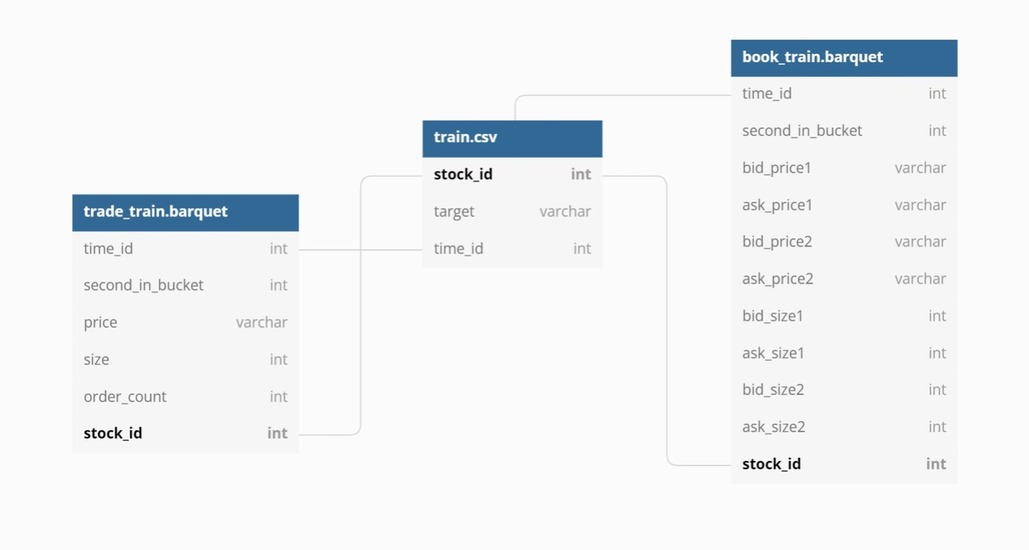



Read file

In [ ]:
root_path = "data"
book_fol = f"{root_path}/book_train.parquet/"
book_files = book_fol + "*"
book_files = glob.glob(book_files)

trade_fol = f"{root_path}/trade_train.parquet/"
trade_files = trade_fol + "*"
trade_files = glob.glob(trade_files)

In [ ]:
book_data_sample = pd.read_parquet(book_files[0])
book_data_sample.describe()

time_id  seconds_in_bucket    bid_price1    ask_price1  \
count  1.827301e+06       1.827301e+06  1.827301e+06  1.827301e+06   
mean   1.602504e+04       2.985170e+02  9.999863e-01  1.000014e+00   
std    9.360747e+03       1.734086e+02  3.171571e-03  3.158696e-03   
min    5.000000e+00       0.000000e+00  9.623416e-01  9.628175e-01   
25%    7.843000e+03       1.480000e+02  9.987453e-01  9.989708e-01   
50%    1.584600e+04       2.980000e+02  9.999204e-01  1.000081e+00   
75%    2.395500e+04       4.490000e+02  1.000987e+00  1.001198e+00   
max    3.276700e+04       5.990000e+02  1.036685e+00  1.037426e+00   

         bid_price2    ask_price2     bid_size1     ask_size1     bid_size2  \
count  1.827301e+06  1.827301e+06  1.827301e+06  1.827301e+06  1.827301e+06   
mean   9.999737e-01  1.000027e+00  4.359868e+02  4.436957e+02  6.431888e+02   
std    3.184272e-03  3.162563e-03  1.030468e+03  9.593258e+02  1.440443e+03   
min    9.622226e-01  9.631745e-01  1.000000e+00  1.000000e+00  1.000000e+00   
25%    9.985849e-01  9.991266e-01  1.930000e+02  2.000000e+02  2.900000e+02   
50%    9.997589e-01  1.000246e+00  3.000000e+02  3.000000e+02  5.000000e+02   
75%    1.000835e+00  1.001355e+00  5.450000e+02  5.530000e+02  8.000000e+02   
max    1.036438e+00  1.037549e+00  1.711590e+05  2.447800e+05  1.715050e+05   

          ask_size2  
count  1.827301e+06  
mean   6.290539e+02  
std    1.124176e+03  
min    1.000000e+00  
25%    2.860000e+02  
50%    5.000000e+02  
75%    8.000000e+02  
max    2.477140e+05

In [ ]:
book_data_sample.dtypes

time_id                int16
seconds_in_bucket      int16
bid_price1           float32
ask_price1           float32
bid_price2           float32
ask_price2           float32
bid_size1              int32
ask_size1              int32
bid_size2              int32
ask_size2              int32
dtype: object

#### __Book files__

         
1. **stock_id**: Stock (which stock) Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
2. **time_id**: id of which time information (linked to time_id in submission file)
3. **seconds_in_bucket**: How many seconds after starting from 0 in time_id? Maybe you're predicting a total volatility of 10 minutes, so seconds_in_bucket should be up to 600 sec  
4. **bid_price1,2**: 1st and 2nd desired bid price of the stock (Normalized prices of the most / second most competitive buy level. )
5. **ask_price1,2**: Desired selling price of the stock(Normalized prices of the most/second most competitive sell level.)

6. **bid_size1,2**: The number of shares on the most/second most competitive buy level.
7. **ask_size1,2**: The number of shares on the most/second most competitive sell level.

In [ ]:
book_data_sample.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.002195    1.002357    1.002032    1.002520   
1        5                  1    1.002195    1.002357    1.002032    1.002520   
2        5                  2    1.002357    1.002520    1.002195    1.002683   
3        5                  3    1.002357    1.002520    1.002195    1.002683   
4        5                  4    1.002357    1.002520    1.002195    1.002683   

   bid_size1  ask_size1  bid_size2  ask_size2  
0        200        513        600        400  
1        600        113        800        400  
2        800        128        600        300  
3        845        105        600        300  
4        200        405        600        300

In [ ]:
# trade data
print(len(trade_files))

112


In [ ]:
trade_data_sample = pd.read_parquet(trade_files[0])
trade_data_sample.describe()

time_id  seconds_in_bucket          price           size  \
count  460123.000000      460123.000000  460123.000000  460123.000000   
mean    15983.813043         297.343276       1.000004     187.462859   
std      9414.024551         173.801060       0.002760     308.402480   
min         5.000000           0.000000       0.956709       1.000000   
25%      7743.000000         146.000000       0.998951      37.000000   
50%     15759.000000         297.000000       1.000000     101.000000   
75%     23834.000000         448.000000       1.001043     224.000000   
max     32767.000000         599.000000       1.041221   54380.000000   

         order_count  
count  460123.000000  
mean        3.309143  
std         3.897888  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         4.000000  
max       506.000000

In [ ]:
trade_data_sample.dtypes

time_id                int16
seconds_in_bucket      int16
price                float32
size                   int32
order_count            int16
dtype: object

#### __Trade files__

**trade_train.parquet** contains data on trades that actually executed in the market. Therefore one may expect this file to be more sparse than the order book.

1. **stock_id** - Same as above.
2. **time_id** - Same as above.
3. **seconds_in_bucket** - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
4. **price** - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
5. **size** - The sum number of shares traded.
6. **order_count** - The number of unique trade orders taking place.

In [ ]:
trade_data_sample.head()

time_id  seconds_in_bucket     price  size  order_count
0        5                  0  1.000257   147            4
1        5                  8  1.000155   100            1
2        5                  9  1.000155   200            3
3        5                 10  1.000181   302            6
4        5                 11  1.000232   201            3

In [ ]:
# train data
target_data = pd.read_csv(f'{root_path}/train.csv')
target_data.head()

stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747

In [ ]:
target_data.shape

(428932, 3)

In [ ]:
target_data.describe()

stock_id        time_id         target
count  428932.000000  428932.000000  428932.000000
mean       62.437944   16038.972721       0.003880
std        37.126450    9365.103706       0.002936
min         0.000000       5.000000       0.000105
25%        30.000000    7854.000000       0.002026
50%        63.000000   15853.000000       0.003048
75%        96.000000   23994.000000       0.004738
max       126.000000   32767.000000       0.070321

# 2. Feature Engineerings

## 2.1 Volatility  
The host is not annualizing the volatility to keep definitions as simple and we are assuming that log returns have 0 mean, where $r$: returns of the stocks.

$$\sigma = \sqrt{\sum{r^2_{t-1,t}}}$$

```python
np.sqrt(np.sum(returns ** 2))
```

## 2.2 Liquidity

In finance, Liquidity refers to the efficiency or ease with which an asset or securitycan be converted into ready cash without affecting its market price. A reasonable numerical definition of liquidity then should start from the following assumptions:  

(To compare the price/volumn of bid price and ask price in the similar range, we use the ratios between each price and volumn)  



### 1. Moving bids closer to asks always increases liquidity  
The price ratios of bid ask:

- ${bid\_ask\_spread\_p_1} = \frac{bid\_price_{1}}{ask\_price_{1}} - 1$

- ${bid\_ask\_spread\_p_2} = \frac{bid\_price_2}{ask\_price_2} - 1$

- ${price\_spread} = \frac{ask\_price_1 - bid\_price_1}{(ask\_price_1 + bid\_price_1)/2}$

The volume ratios bid ask:

- $bid\_ask\_spead\_v_1 = abs[\frac{bid\_size_1}{ask\_size_1} - 1]$

- $bid\_ask\_spread_v2 = abs[\frac{bid\_size_2}{ask\_size_2} - 1]$

- $bid\_ask\_depth\_ratio = \frac{bid\_size_1+bid\_size_2}{ask\_size1_+ask\_size_2} -1$

```python
df['bid_ask_spread_p1'] = df['bid_price1'] / df['ask_price1'] - 1 
df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2) 
df['bid_ask_spread_v1'] = abs(df['bid_size1']/df['ask_size1'] - 1)

df['bid_ask_spread_p2'] = df['bid_price2'] / df['ask_price2'] - 1 
df['bid_ask_pread_v2'] = abs((df['bid_size1'] + df['ask_size1']) / (df['bid_size2'] + df['ask_size2']) - 1) 

df['bid_ask_depth_ratio'] = (df['bid_size1'] + df['bid_size2']) / (df['ask_size1'] + df['ask_size2']) 
```


**2. Increasing order sizes always increases liquidity**  

- $bid\_size = bid\_size_1 + bid\_size_2$
- $ask\_size = ask\_size_1 + ask\_size_2$  

```python
df['bid_size'] = df['bid_size1'] + df['bid_size2'] 
df['ask_size' ] = df['ask_size1'] + df['ask_size2'] 
```


**3.  High asymetrics information then resulting in low liquility in the market.)**  
  
bid/ask spreads: dealer should widen the bid-ask spread when they suspect that the information they possessed benefiting them. This situation leads to high asymetrics information then resulting in low liquility in the market.

- $bid\_spread = bid\_price_1 - bid\_price_2$

- $ask\_spread = ask\_price_1 - ask\_price_2$

- $wap\_spread = \frac{wap_2}{wap_1} - 1$

- $bid\_ask\_spread = \frac{ask\_price_1}{bid\_price_1} - 1$

```python
df['bid_spread'] = df['bid_price1'] / df['bid_price2'] - 1 
df['ask_spread'] = df['ask_price1'] / df['ask_price2'] - 1 
df['wap_spread'] = df['wap2'] / df['wap1'] - 1 
```


## 2.4 Create Merge Table

In [ ]:
def realized_volatility(returns):
    return np.sqrt(np.sum(returns ** 2))

In [ ]:
def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret

In [ ]:
book_features = {
        'seconds_in_bucket': ['count'],
#  
        'wap1': [np.mean, np.std, np.sum, np.min,  np.max], 
        'wap2': [np.mean, np.std, np.sum, np.min,  np.max], 
#    
        'log_return1': [realized_volatility, np.mean, np.std, np.sum, np.min,  np.max],
        'log_return2': [realized_volatility, np.mean, np.std, np.sum, np.min,  np.max],
#    
        'bid_ask_spread_p1': [np.mean, np.std, np.sum, np.min,  np.max], # liquidity
        'price_spread':[np.mean, np.std, np.sum, np.min,  np.max], #
        'bid_ask_spread_v1':[np.mean, np.std, np.sum, np.min,  np.max], # liquidity
        'bid_ask_spread_p2':[np.mean, np.std, np.sum, np.min,  np.max], 
        'bid_ask_pread_v2':[np.mean, np.std, np.sum, np.min,  np.max],
        'bid_spread':[np.mean, np.std, np.sum, np.min,  np.max], 
        'ask_spread':[np.mean, np.std, np.sum, np.min,  np.max], 
        'wap_spread':[np.mean, np.std, np.sum, np.min,  np.max], 

#
        'bid_size':[np.sum, np.mean, np.std, np.min,  np.max], # liquidity
        'ask_size':[np.sum, np.mean, np.std, np.min,  np.max], # liquidity
        'bid_ask_depth_ratio':[np.sum, np.mean, np.std, np.min,  np.max], # liquidity
#         
        'bid_price1':[np.sum, np.min,  np.max], 
        'ask_price1':[np.sum, np.min,  np.max]   
   
}

def create_book_train_df (path_list):
    list_of_df = []
    for i in tqdm(path_list):
        df = pd.read_parquet(i)
        stock_id = i.split("/")[-1].split("=")[-1]
        
        # basic features
        ## average price = wap
        
        df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.ask_size1 + df.bid_size1)
        df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price1 * df.bid_size1) / (df.ask_size1 + df.bid_size1)
        
        ## return

        df = df.sort_values(by=['time_id','seconds_in_bucket'], ascending=[True,True])
        df['previous_wap1'] = df.groupby(['time_id'])['wap1'].shift(1)
        df['previous_wap2'] = df.groupby(['time_id'])['wap2'].shift(1)
        df['log_return1'] = (df['wap1']/df['previous_wap1']).apply(lambda x: math.log(x))
        df['log_return2'] = (df['wap2']/df['previous_wap2']).apply(lambda x: math.log(x))
        
        ## liquidity

        df['bid_ask_spread_p1'] = df['bid_price1'] / df['ask_price1'] - 1 # liquidity (1)
        df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2) # liquidity (1)
        df['bid_ask_spread_v1'] = abs(df['bid_size1']/df['ask_size1'] - 1) # liquidity (1)

        df['bid_ask_spread_p2'] = df['bid_price2'] / df['ask_price2'] - 1 # liquidity (1)
        df['bid_ask_pread_v2'] = abs((df['bid_size1'] + df['ask_size1']) / (df['bid_size2'] + df['ask_size2']) - 1) # liquidity (1)

        df['bid_ask_depth_ratio'] = (df['bid_size1'] + df['bid_size2']) / (df['ask_size1'] + df['ask_size2']) # liquidity (1)
    
        df['bid_size'] = df['bid_size1'] + df['bid_size2'] # liquidity (2)
        df['ask_size' ] = df['ask_size1'] + df['ask_size2'] # liquidity (2)
        
        df['bid_spread'] = df['bid_price1'] / df['bid_price2'] - 1 # liquidity (3)
        df['ask_spread'] = df['ask_price1'] / df['ask_price2'] - 1 # liquidity (3)
        df['wap_spread'] = df['wap2'] / df['wap1'] - 1 # liquidity (3)

        ## aggregate df

        df_agg = df.groupby('time_id').agg(book_features).reset_index(drop=False)
        df_agg.columns = flatten_name('book', df_agg.columns)
        df_agg['book.bid_ask_spread.overall'] = df_agg['book.bid_price1.amax']/df_agg['book.ask_price1.amin'] - 1
        
        df_agg['stock_id'] = stock_id
        df_agg['row_id'] = df_agg['time_id'].apply(lambda x: f"{str(stock_id)}-{str(x)}")
                
        list_of_df = list_of_df + [df_agg]
    return pd.concat(list_of_df)

book_df = create_book_train_df(book_files)
print(book_df.dtypes)
book_df.head(10)

100%|██████████| 112/112 [10:57<00:00,  5.87s/it]


time_id                           int64
book.seconds_in_bucket.count      int64
book.wap1.mean                  float64
book.wap1.std                   float64
book.wap1.sum                   float64
                                 ...   
book.ask_price1.amin            float32
book.ask_price1.amax            float32
book.bid_ask_spread.overall     float32
stock_id                         object
row_id                           object
Length: 88, dtype: object


time_id  book.seconds_in_bucket.count  book.wap1.mean  book.wap1.std  \
0        5                           527        1.003427       0.000886   
1       11                           388        1.000401       0.000480   
2       16                           366        0.998669       0.000250   
3       31                           432        0.999998       0.000669   
4       62                           356        0.998813       0.000522   
5       72                           529        1.000761       0.002341   
6       97                           449        0.999653       0.000932   
7      103                           449        0.997162       0.000647   
8      109                           517        1.000880       0.000662   
9      123                           474        1.003245       0.001588   

   book.wap1.sum  book.wap1.amin  book.wap1.amax  book.wap2.mean  \
0     528.805908        1.001257        1.004584        1.808876   
1     388.155701        0.999696        1.001302        1.289206   
2     365.512939        0.997847        0.999336        1.346110   
3     431.999268        0.998889        1.001723        1.504212   
4     355.577515        0.997929        0.999548        1.244022   
5     529.402649        0.997393        1.005297        1.287500   
6     448.844360        0.997948        1.001426        1.192647   
7     447.725769        0.996065        0.999309        1.278622   
8     517.455078        0.999361        1.002506        1.168253   
9     475.538177        1.000041        1.006208        1.161740   

   book.wap2.std  book.wap2.sum  ...  book.bid_ask_depth_ratio.amax  \
0       0.902053     953.277405  ...                       8.406863   
1       0.597946     500.211884  ...                       3.445000   
2       0.717219     492.676422  ...                       4.855000   
3       0.760551     649.819580  ...                       4.316428   
4       0.429577     442.871735  ...                       4.482468   
5       1.001936     681.087280  ...                       6.500000   
6       0.799542     535.498291  ...                     163.145000   
7       0.610974     574.101074  ...                       8.995000   
8       0.458967     603.987000  ...                       8.163009   
9       2.222897     550.664673  ...                       9.909910   

   book.bid_price1.sum  book.bid_price1.amin  book.bid_price1.amax  \
0           528.752441              1.001057              1.004471   
1           388.126923              0.999629              1.001262   
2           365.474030              0.997778              0.999259   
3           431.947662              0.998858              1.001669   
4           355.542206              0.997879              0.999406   
5           529.323181              0.997389              1.004984   
6           448.772705              0.997677              1.001230   
7           447.670685              0.995988              0.999228   
8           517.403259              0.999312              1.002369   
9           475.465027              1.000000              1.005925   

   book.ask_price1.sum  book.ask_price1.amin  book.ask_price1.amax  \
0           528.856812              1.001382              1.004634   
1           388.184784              0.999777              1.001410   
2           365.550140              0.997913              0.999529   
3           432.044281              0.999034              1.001845   
4           355.611786              0.998049              0.999576   
5           529.494812              0.997706              1.005300   
6           448.895721              0.997950              1.001503   
7           447.783020              0.996296              0.999537   
8           517.496338              0.999465              1.002522   
9           475.624420              1.000289              1.006214   

   book.bid_ask_spread.overall  stock_id  row_id  
0                     0.003085        99    99-5  
1 

In [ ]:
book_features = pd.read_csv(f"{root_path}/book_features.csv")
book_features.head()

time_id  book.seconds_in_bucket.count  book.wap1.mean  book.wap1.std  \
0        5                           527        1.003427       0.000886   
1       11                           388        1.000401       0.000480   
2       16                           366        0.998669       0.000250   
3       31                           432        0.999998       0.000669   
4       62                           356        0.998813       0.000522   

   book.wap1.sum  book.wap1.amin  book.wap1.amax  book.wap2.mean  \
0     528.805908        1.001257        1.004584        1.808876   
1     388.155701        0.999696        1.001302        1.289206   
2     365.512939        0.997847        0.999336        1.346110   
3     431.999268        0.998889        1.001723        1.504212   
4     355.577515        0.997929        0.999548        1.244022   

   book.wap2.std  book.wap2.sum  ...  book.bid_ask_depth_ratio.amax  \
0       0.902053     953.277405  ...                       8.406863   
1       0.597946     500.211884  ...                       3.445000   
2       0.717219     492.676422  ...                       4.855000   
3       0.760551     649.819580  ...                       4.316428   
4       0.429577     442.871735  ...                       4.482468   

   book.bid_price1.sum  book.bid_price1.amin  book.bid_price1.amax  \
0            528.75244              1.001057              1.004471   
1            388.12692              0.999629              1.001262   
2            365.47403              0.997778              0.999259   
3            431.94766              0.998858              1.001669   
4            355.54220              0.997879              0.999406   

   book.ask_price1.sum  book.ask_price1.amin  book.ask_price1.amax  \
0            528.85680              1.001382              1.004634   
1            388.18478              0.999777              1.001410   
2            365.55014              0.997913              0.999529   
3            432.04428              0.999034              1.001845   
4            355.61180              0.998049              0.999576   

   book.bid_ask_spread.overall  stock_id  row_id  
0                     0.003085        99    99-5  
1                     0.001485        99   99-11  
2                     0.001349        99   99-16  
3                     0.002638        99   99-31  
4                     0.001360        99   99-62  

[5 rows x 91 columns]

In [ ]:
trade_features = {
'seconds_in_bucket': ['count'],    
'price': [realized_volatility, np.mean, np.std, np.sum, np.min,  np.max],
'size':[np.mean, np.std, np.sum, np.min,  np.max],
'order_count':[np.mean, np.std, np.sum, np.min,  np.max],
'trade_volumn':[np.mean, np.std, np.sum, np.min, np.max],
'weighted_price': [realized_volatility, np.mean, np.std, np.sum, np.min,  np.max],
}

def create_trade_train_df(path_list):
    list_of_df = []
    for i in tqdm(path_list):
        df = pd.read_parquet(i)
        stock_id = i.split("/")[-1].split("=")[-1]
        df['stock_id'] = stock_id
        df['trade_volumn'] = df['price']*df['size']
        df['weighted_price'] = df['trade_volumn'] / df['size']
        df['row_id'] = df['time_id'].apply(lambda x: f"{str(stock_id)}-{str(x)}")
        df_agg = df.groupby('time_id').agg(trade_features).reset_index(drop=False)
        df_agg.columns = flatten_name('trade', df_agg.columns)        
        df_agg['stock_id'] = stock_id
        df_agg['row_id'] = df_agg['time_id'].apply(lambda x: f"{str(stock_id)}-{str(x)}")
        list_of_df = list_of_df + [df_agg]
        
    return pd.concat(list_of_df)

trade_df = create_trade_train_df (trade_files)
print(trade_df.dtypes)
trade_df.head(10)    
    

100%|██████████| 112/112 [05:23<00:00,  2.89s/it]


time_id                                       int64
trade.seconds_in_bucket.count                 int64
trade.price.realized_volatility             float32
trade.price.mean                            float32
trade.price.std                             float64
trade.price.sum                             float32
trade.price.amin                            float32
trade.price.amax                            float32
trade.size.mean                             float64
trade.size.std                              float64
trade.size.sum                                int32
trade.size.amin                               int32
trade.size.amax                               int32
trade.order_count.mean                      float64
trade.order_count.std                       float64
trade.order_count.sum                       float64
trade.order_count.amin                        int16
trade.order_count.amax                        int16
trade.trade_volumn.mean                     float64
trade.trade_

time_id  trade.seconds_in_bucket.count  trade.price.realized_volatility  \
0        5                            255                        16.004286   
1       11                            105                        10.256066   
2       16                             89                         9.430665   
3       31                             66                         8.122451   
4       62                             66                         8.119877   
5       72                            186                        13.656346   
6       97                            101                        10.028729   
7      103                            245                        15.666622   
8      109                            136                        11.660358   
9      123                            215                        14.704476   

   trade.price.mean  trade.price.std  trade.price.sum  trade.price.amin  \
0          1.002227         0.001003       255.567810          1.000155   
1          1.000889         0.000439       105.093391          0.999857   
2          0.999648         0.000335        88.968712          0.998943   
3          0.999805         0.000393        65.987099          0.999181   
4          0.999488         0.000338        65.966187          0.998925   
5          1.001332         0.000576       186.247696          1.000114   
6          0.997896         0.000737       100.787460          0.996768   
7          1.000903         0.000707       245.221359          0.999658   
8          0.999867         0.000864       135.981918          0.998280   
9          1.002837         0.000671       215.609909          1.000772   

   trade.price.amax  trade.size.mean  trade.size.std  ...  \
0          1.003560       140.109804      165.359986  ...   
1          1.001652       226.628571      242.518804  ...   
2          1.000340       231.932584      223.418268  ...   
3          1.000649       196.363636      193.771685  ...   
4          1.000120        84.045455      118.524705  ...   
5          1.002624       215.591398      242.134461  ...   
6          0.999814       178.900990      266.467240  ...   
7          1.002496       107.946939      137.935039  ...   
8          1.001299        93.323529      101.410050  ...   
9          1.003760       222.041860      266.337961  ...   

   trade.trade_volumn.amin  trade.trade_volumn.amax  \
0                 1.000309               961.304970   
1                 2.001143              1161.268606   
2                 0.999245              1077.089267   
3                 0.999214               832.831784   
4                 0.998995               617.519000   
5                 1.000266              1218.121758   
6                 0.997213              1544.624376   
7                 0.999734               886.644067   
8                 0.998340               512.510803   
9                 1.003052              1386.937310   

   trade.weighted_price.realized_volatility  trade.weighted_price.mean  \
0                                 16.004285                   1.002227   
1                                 10.256066                   1.000889   
2                                  9.430665                   0.999648   
3                                  8.122451                   0.999805   
4                                  8.119877                   0.999488   
5                                 13.656346                   1.001332   
6                                 10.028730                   0.997896   
7                                 15.666622                   1.000904   
8                                 11.660358                   0.999867   
9                                 14.704477                   1.002837   

   trade.weighted_price.std  trade.weighted_price.sum  \
0                  0.001003                255.567812   
1                  0.000439                105.093394   
2                  0.000335                 88.968712 

Merge all features to a dataframe 

In [ ]:
feature_data = book_df.merge(trade_df, on=['row_id','time_id','stock_id'],how='left')

In [ ]:
feature_data.head()

time_id  book.seconds_in_bucket.count  book.wap1.mean  book.wap1.std  \
0        5                           527        1.003427       0.000886   
1       11                           388        1.000401       0.000480   
2       16                           366        0.998669       0.000250   
3       31                           432        0.999998       0.000669   
4       62                           356        0.998813       0.000522   

   book.wap1.sum  book.wap1.amin  book.wap1.amax  book.wap2.mean  \
0     528.805908        1.001257        1.004584        1.808876   
1     388.155701        0.999696        1.001302        1.289206   
2     365.512939        0.997847        0.999336        1.346110   
3     431.999268        0.998889        1.001723        1.504212   
4     355.577515        0.997929        0.999548        1.244022   

   book.wap2.std  book.wap2.sum  ...  trade.trade_volumn.std  \
0       0.902053     953.277405  ...              424.868401   
1       0.597946     500.211884  ...              748.852110   
2       0.717219     492.676422  ...              669.962693   
3       0.760551     649.819580  ...              449.940265   
4       0.429577     442.871735  ...              472.371808   

   trade.trade_volumn.sum  trade.trade_volumn.amin  trade.trade_volumn.amax  \
0            39846.340830                 1.003333              4081.349194   
1            35803.727387                 1.000965              3201.765040   
2            24042.357572                 0.998451              5525.030068   
3            22989.139908                 1.000263              3237.330010   
4            19394.192250                 1.998134              2451.543162   

   trade.weighted_price.realized_volatility  trade.weighted_price.mean  \
0                                 11.262612                   1.003353   
1                                  7.486925                   1.000482   
2                                  8.355368                   0.998657   
3                                  8.366613                   1.000001   
4                                  6.773758                   0.998736   

   trade.weighted_price.std  trade.weighted_price.sum  \
0                  0.000855                126.422464   
1                  0.000495                 56.027009   
2                  0.000248                 69.906018   
3                  0.000704                 70.000088   
4                  0.000393                 45.941860   

   trade.weighted_price.amin  trade.weighted_price.amax  
0                   1.001220                   1.004471  
1                   0.999777                   1.001262  
2                   0.998050                   0.999259  
3                   0.999034                   1.001597  
4                   0.998049                   0.999406  

[5 rows x 116 columns]

In [ ]:
#book_df.to_csv(f"{root_path}/book_features.csv", index = False)
#trade_df.to_csv(f"{root_path}/trade_features.csv", index = False)
#feature_data.to_csv(f"{root_path}/features_data.csv", index = False)
#book_df = pd.read_csv(f'{root_path}/book_features.csv')
#trade_df = pd.read_csv(f'{root_path}/trade_features.csv')
#feature_data = pd.read_csv(f'{root_path}/features_data.csv')

Complete the final dataset (features + target)

In [ ]:
feature_data = feature_data.drop(columns = ['time_id','book.seconds_in_bucket.count', 'trade.seconds_in_bucket.count'])
first_column = feature_data.pop('row_id')
feature_data.insert(0, 'row_id', first_column)

target_data = pd.read_csv(f'{root_path}/train.csv')
target_data['row_id'] = target_data["stock_id"].astype(str) + "-" + target_data["time_id"].astype(str)

target_data.drop(columns = ['stock_id'], inplace = True)
dataset = feature_data.merge(target_data, how = 'left', on = 'row_id')
dataset.drop(columns = ['time_id','stock_id'], inplace = True)

In [ ]:
dataset.describe()

book.wap1.mean  book.wap1.std  book.wap1.sum  book.wap1.amin  \
count   428932.000000  428932.000000  428932.000000   428932.000000   
mean         1.000003       0.001110     389.927917        0.997718   
std          0.003370       0.001052     135.835208        0.003891   
min          0.917331       0.000016      24.002597        0.883063   
25%          0.998840       0.000509     275.410779        0.996790   
50%          1.000012       0.000807     387.714478        0.998526   
75%          1.001166       0.001335     511.600136        0.999612   
max          1.079311       0.034370     634.409851        1.049434   

       book.wap1.amax  book.wap2.mean  book.wap2.std  book.wap2.sum  \
count   428932.000000   428932.000000  428932.000000  428932.000000   
mean         1.002266        1.738128       3.597317     647.991404   
std          0.003804        1.500793       8.471444     529.786163   
min          0.947885        0.237649       0.007050      18.034895   
25%          1.000427        1.164063       0.642134     405.589636   
50%          1.001481        1.372107       1.617767     582.925293   
75%          1.003128        1.851962       4.562170     772.430527   
max          1.127077      409.973114    2770.003313  135291.125000   

       book.wap2.amin  book.wap2.amax  ...  trade.trade_volumn.sum  \
count   428932.000000   428932.000000  ...            4.289130e+05   
mean         0.140302       40.568964  ...            3.186054e+04   
std          0.166019      104.067784  ...            7.026346e+04   
min          0.000095        0.456296  ...            9.992360e-01   
25%          0.019760        5.461583  ...            4.998448e+03   
50%          0.058508       18.006956  ...            1.161229e+04   
75%          0.219939       50.637172  ...            2.943196e+04   
max          2.627687    31067.517578  ...            4.158028e+06   

       trade.trade_volumn.amin  trade.trade_volumn.amax  \
count            428913.000000            428913.000000   
mean                  6.387786              3035.392403   
std                 352.428510              8194.235058   
min                   0.898541                 0.999236   
25%                   0.998114               599.617830   
50%                   0.999647              1036.361441   
75%                   1.001205              2397.987700   
max               88198.258545            729370.329305   

       trade.weighted_price.realized_volatility  trade.weighted_price.mean  \
count                             428913.000000              428913.000000   
mean                                   8.725068                   0.999996   
std                                    3.654918                   0.003434   
min                                    0.976295                   0.918282   
25%                                    6.166582                   0.998807   
50%                                    7.932888                   1.000007   
75%                                   10.419858                   1.001184   
max                                   25.219004                   1.087380   

       trade.weighted_price.std  trade.weighted_price.sum  \
count             428852.000000             428913.000000   
mean                   0.001098                 89.485854   
std                    0.001050                 82.828516   
min                    0.000000                  0.976295   
25%                    0.000497                 38.013481   
50%                    0.000794                 62.964159   
75%                    0.001321                108.671085   
max                    0.027348                617.212402   

       trade.weighted_price.amin  trade.weighted_price.amax         target  
count              428913.000000              428913.000000  428932.000000  
mean                    0.997926                   1.002051       0.003880  
std                     0.003876                   0.003781       0.002936  
min

# 3. EDA

## 3.1 Describe merging data

## 3.2 Detecting & Handling missing data

In [ ]:
# data missing rate
df_na = (dataset.isnull().sum() / len(dataset)) * 100
df_na_volume = dataset.isnull().sum()
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'miss_rate (%)' :df_na,'miss_volume': df_na_volume})
missing_data[missing_data.miss_volume > 0].sort_values(by = ['miss_volume'], ascending = [False])

miss_rate (%)  miss_volume
trade.weighted_price.std                       0.018651           80
trade.order_count.std                          0.018651           80
trade.price.std                                0.018651           80
trade.trade_volumn.std                         0.018651           80
trade.size.std                                 0.018651           80
trade.order_count.amax                         0.004430           19
trade.size.sum                                 0.004430           19
trade.weighted_price.realized_volatility       0.004430           19
trade.weighted_price.mean                      0.004430           19
trade.weighted_price.amin                      0.004430           19
trade.weighted_price.amax                      0.004430           19
trade.trade_volumn.sum                         0.004430           19
trade.trade_volumn.mean                        0.004430           19
trade.trade_volumn.amin                        0.004430           19
trade.trade_volumn.amax                        0.004430           19
trade.size.mean                                0.004430           19
trade.order_count.amin                         0.004430           19
trade.size.amin                                0.004430           19
trade.size.amax                                0.004430           19
trade.price.sum                                0.004430           19
trade.price.realized_volatility                0.004430           19
trade.price.mean                               0.004430           19
trade.price.amin                               0.004430           19
trade.price.amax                               0.004430           19
trade.order_count.sum                          0.004430           19
trade.order_count.mean                         0.004430           19
trade.weighted_price.sum                       0.004430           19

In [ ]:
means = dataset._get_numeric_data().mean()
dataset=dataset.fillna(means)

## 3.3 Outliers in target variable

count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64

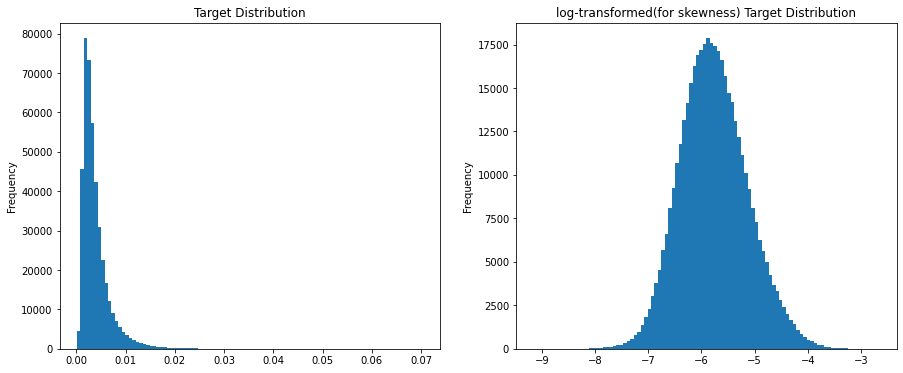

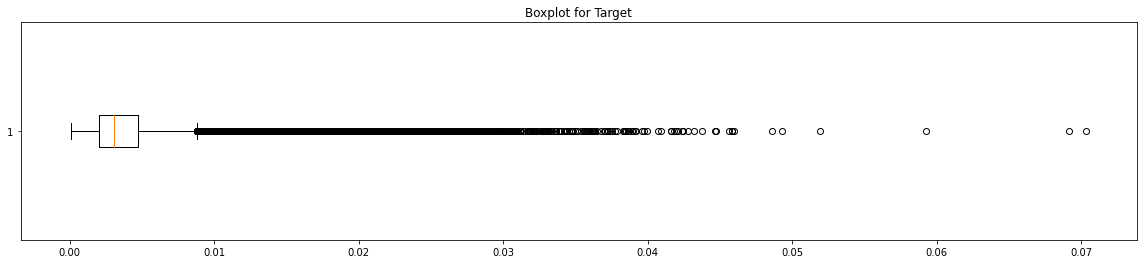

In [ ]:
display(dataset["target"].describe())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
dataset["target"].plot(kind="hist", bins=100, ax=axs[0], title="Target Distribution")
np.log(dataset["target"]).plot(kind="hist", bins=100, ax=axs[1], title="log-transformed(for skewness) Target Distribution")

plt.figure(figsize=(20, 4))
plt.boxplot(dataset["target"], vert=False)
plt.title("Boxplot for Target")
plt.show()

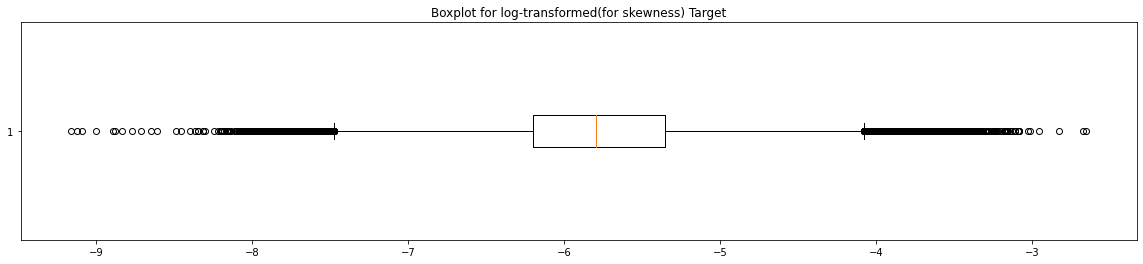

In [ ]:
plt.figure(figsize=(20, 4))
plt.boxplot(np.log(dataset["target"]), vert=False)
plt.title("Boxplot for log-transformed(for skewness) Target")
plt.show()

## 3.4 Data Scaling

In [ ]:
name = []
max_value = []
min_value = []
for fe in dataset.columns:
  name.append(fe)
  max_value.append(dataset[fe].max())
  min_value.append(dataset[fe].min())

table = pd.DataFrame(list(zip(name,max_value,min_value)), columns =['name','max','min'])

In [ ]:
table.drop(table.tail(1).index,inplace=True)
table.drop(table.head(1).index,inplace=True)
name_over_one = table[(table['max'] > 1) | (table['min'] < 0)]

col_scale = name_over_one['name'].reset_index(drop = True)

### scaling data
scaler = MinMaxScaler()
#scaler = StandardScaler()

# fit the scaler to our data
scaled_df = scaler.fit_transform(dataset[col_scale])

# scale our data
dataset[col_scale] = scaled_df

In [ ]:
dataset['stock_id'] = dataset['row_id'].str.split('-',expand = True)[0]

In [ ]:
scaled_data = dataset.copy()

In [ ]:
scaled_data

row_id  book.wap1.mean  book.wap1.std  book.wap1.sum  book.wap1.amin  \
0          99-5        0.531519       0.000886       0.826994        0.710426   
1         99-11        0.512842       0.000480       0.596574        0.701046   
2         99-16        0.502149       0.000250       0.559479        0.689931   
3         99-31        0.510354       0.000669       0.668401        0.696192   
4         99-62        0.503038       0.000522       0.543203        0.690420   
...         ...             ...            ...            ...             ...   
428927  0-32751        0.497632       0.000747       0.446235        0.680581   
428928  0-32753        0.512279       0.000551       0.298262        0.698847   
428929  0-32758        0.507596       0.000743       0.268531        0.691191   
428930  0-32763        0.524917       0.000356       0.464806        0.711727   
428931  0-32767        0.504949       0.000765       0.333871        0.690256   

        book.wap1.amax  book.wap2.mean  book.wap2.std  book.wap2.sum  \
0             0.316414        0.003835       0.000323       0.006914   
1             0.298102        0.002566       0.000213       0.003564   
2             0.287131        0.002705       0.000256       0.003509   
3             0.300447        0.003091       0.000272       0.004670   
4             0.288314        0.002456       0.000153       0.003141   
...                ...             ...            ...            ...   
428927        0.284431        0.007431       0.004334       0.007073   
428928        0.299229        0.002001       0.000803       0.001477   
428929        0.294724        0.005636       0.002187       0.003406   
428930        0.308074        0.005362       0.002698       0.005393   
428931        0.292832        0.001682       0.000156       0.001429   

        book.wap2.amin  ...  trade.trade_volumn.amin  trade.trade_volumn.amax  \
0             0.182474  ...                 0.000001                 0.005594   
1             0.128292  ...                 0.000001                 0.004388   
2             0.106748  ...                 0.000001                 0.007574   
3             0.069313  ...                 0.000001                 0.004437   
4             0.226220  ...                 0.000012                 0.003360   
...                ...  ...                      ...                      ...   
428927        0.002568  ...                 0.000001                 0.000687   
428928        0.001449  ...                 0.000001                 0.001058   
428929        0.034633  ...                 0.000001                 0.000822   
428930        0.004219  ...                 0.000001                 0.000525   
428931        0.117429  ...                 0.000001                 0.000760   

        trade.weighted_price.realized_volatility  trade.weighted_price.mean  \
0                                       0.424306                   0.503085   
1                                       0.268560                   0.486109   
2                                       0.304383                   0.475317   
3                                       0.304847                   0.483264   
4                                       0.239143                   0.475782   
...                                          ...                        ...   
428927                                  0.256456                   0.468804   
428928                                  0.178071                   0.485180   
428929                                  0.207135                   0.481089   
428930                                  0.260722                   0.496890   
428931                                  0.181638                   0.477257   

        trade.weighted_price.std  trade.weighted_price.sum  \
0                       0.000855                  0.203568   
1                       0.000495                  0.089334   
2                       0.000248                  0.111856   
3

In [ ]:
scaled_data = pd.read_csv(f'{root_path}/scaled_data.csv')

In [ ]:
scaled_data.describe()

book.wap1.mean  book.wap1.std  book.wap1.sum  book.wap1.amin  \
count   428932.000000  428932.000000  428932.000000   428932.000000   
mean         0.510385       0.001110       0.599477        0.689156   
std          0.020808       0.001052       0.222532        0.023386   
min          0.000000       0.000016       0.000000        0.000000   
25%          0.503205       0.000509       0.411870        0.683578   
50%          0.510439       0.000807       0.595851        0.694010   
75%          0.517560       0.001335       0.798807        0.700537   
max          1.000000       0.034370       1.000000        1.000000   

       book.wap1.amax  book.wap2.mean  book.wap2.std  book.wap2.sum  \
count   428932.000000   428932.000000  428932.000000  428932.000000   
mean         0.303477        0.003662       0.001296       0.004657   
std          0.021230        0.003663       0.003058       0.003916   
min          0.000000        0.000000       0.000000       0.000000   
25%          0.293216        0.002261       0.000229       0.002865   
50%          0.299097        0.002769       0.000581       0.004176   
75%          0.308289        0.003940       0.001644       0.005577   
max          1.000000        1.000000       1.000000       1.000000   

       book.wap2.amin  book.wap2.amax  ...  trade.trade_volumn.amin  \
count   428932.000000   428932.000000  ...            428932.000000   
mean         0.053359        0.001291  ...                 0.000062   
std          0.063183        0.003350  ...                 0.003996   
min          0.000000        0.000000  ...                 0.000000   
25%          0.007484        0.000161  ...                 0.000001   
50%          0.022230        0.000565  ...                 0.000001   
75%          0.083667        0.001615  ...                 0.000001   
max          1.000000        1.000000  ...                 1.000000   

       trade.trade_volumn.amax  trade.weighted_price.realized_volatility  \
count            428932.000000                             428932.000000   
mean                  0.004160                                  0.319633   
std                   0.011234                                  0.150760   
min                   0.000000                                  0.000000   
25%                   0.000821                                  0.214098   
50%                   0.001420                                  0.286960   
75%                   0.003287                                  0.389536   
max                   1.000000                                  1.000000   

       trade.weighted_price.mean  trade.weighted_price.std  \
count              428932.000000             428932.000000   
mean                    0.483231                  0.001098   
std                     0.020307                  0.001050   
min                     0.000000                  0.000000   
25%                     0.476204                  0.000497   
50%                     0.483295                  0.000794   
75%                     0.490261                  0.001321   
max                     1.000000                  0.027348   

       trade.weighted_price.sum  trade.weighted_price.amin  \
count             428932.000000              428932.000000   
mean                   0.143629                   0.674818   
std                    0.134407                   0.023855   
min                    0.000000                   0.000000   
25%                    0.060102                   0.669033   
50%                    0.100593                   0.679541   
75%                    0.174755                   0.686187   
max                    1.000000                   1.000000   

       trade.weighted_price.amax         target       stock_id  
count              428932.000000  428932.000000  428932.000000  
mean                    0.319571       0.003880      62.437944  
std                     0.020916       0.002936      37.126450  
min                     

## 3.5 Feature Importances

Use Information gain for feature selections:  
 - Low cost to process
 - Information gain based on entropy, which is suitable for ensemble methods


In [ ]:
%%time
# information gain
from sklearn.feature_selection import mutual_info_regression
features = scaled_data[scaled_data.columns.drop(list(scaled_data.filter(regex='stock_id')))].sample(frac=0.25).drop(columns=['target','row_id'], axis = 0).columns
X_features = scaled_data[features]
y_target = scaled_data.target

importances = mutual_info_regression(X_features, y_target)
feat_importances = pd.DataFrame()
feat_importances['features'] = X_features.columns
feat_importances['importance'] = importances
feat_importances.sort_values(by = ['importance'], ascending=False).head(50)


In [ ]:
#feat_importances.to_csv(f'{root_path}/feat_importances.csv',index = False)

feat_importances = pd.read_csv(f'{root_path}/feat_importances.csv')
feat_importances.sort_values(by = ['importance'], ascending=False).head(50)

features  importance
10   book.log_return1.realized_volatility    0.912666
12                   book.log_return1.std    0.761167
29                  book.price_spread.sum    0.636565
24             book.bid_ask_spread_p1.sum    0.636261
14                  book.log_return1.amin    0.587537
15                  book.log_return1.amax    0.583500
31                 book.price_spread.amax    0.494970
25            book.bid_ask_spread_p1.amin    0.494969
39             book.bid_ask_spread_p2.sum    0.448771
40            book.bid_ask_spread_p2.amin    0.448012
22            book.bid_ask_spread_p1.mean    0.446820
27                 book.price_spread.mean    0.446810
23             book.bid_ask_spread_p1.std    0.444665
28                  book.price_spread.std    0.444560
38             book.bid_ask_spread_p2.std    0.414988
51                   book.bid_spread.amax    0.410001
55                   book.ask_spread.amin    0.405268
48                    book.bid_spread.std    0.401591
53                    book.ask_spread.std    0.396751
1                           book.wap1.std    0.395968
37            book.bid_ask_spread_p2.mean    0.392517
107              trade.weighted_price.std    0.365636
86                        trade.price.std    0.365635
83            book.bid_ask_spread.overall    0.303063
78                   book.bid_price1.amin    0.190784
30                 book.price_spread.amin    0.186694
26            book.bid_ask_spread_p1.amax    0.186599
3                          book.wap1.amin    0.181223
88                       trade.price.amin    0.176992
109             trade.weighted_price.amin    0.176972
82                   book.ask_price1.amax    0.169105
81                   book.ask_price1.amin    0.166897
13                   book.log_return1.sum    0.164001
4                          book.wap1.amax    0.161972
41            book.bid_ask_spread_p2.amax    0.160853
85                       trade.price.mean    0.159091
106             trade.weighted_price.mean    0.159083
0                          book.wap1.mean    0.158459
89                       trade.price.amax    0.158135
110             trade.weighted_price.amax    0.158107
11                  book.log_return1.mean    0.155387
79                   book.bid_price1.amax    0.150446
52                   book.ask_spread.mean    0.149760
47                   book.bid_spread.mean    0.146395
46             book.bid_ask_pread_v2.amax    0.122772
44              book.bid_ask_pread_v2.sum    0.119651
54                    book.ask_spread.sum    0.119256
16   book.log_return2.realized_volatility    0.115554
49                    book.bid_spread.sum    0.115122
18                   book.log_return2.std    0.114669

In [ ]:
# auto generate features
feat_importances = feat_importances.sort_values(by = ['importance'], ascending=False)
list_of_features = feat_importances.features
X_features_data_list = []
for i in [30,35,40,45,50,55,60,65,70,75,80,85,90,95,105]:
    column_list = list(list_of_features[0:i]) + ['target']
    df = scaled_data[column_list]
    X_features_data_list = X_features_data_list + [df]

def get_X_y(data):
  Xfeature = data.drop(columns = ["target"])
  y = data["target"]
  return Xfeature,y

Xfull_train_list = []
Xfull_test_list = []
yfull_train_list = []
yfull_test_list = []

for i in X_features_data_list:
    Xfull, yfull = get_X_y(i)
    Xfull_train, Xfull_test, yfull_train, yfull_test = train_test_split(Xfull, yfull, test_size = 0.2, random_state = 42)
    Xfull_train_list = Xfull_train_list + [Xfull_train]
    Xfull_test_list = Xfull_test_list + [Xfull_test]
    yfull_train_list = yfull_train_list + [yfull_train]
    yfull_test_list = yfull_test_list + [yfull_test]


## 3.6 Scatter plot some features with realized volatility

100%|██████████| 116/116 [00:02<00:00, 45.88it/s]


                                 features  correlation_results
9                                  target             1.000000
71   book.log_return1.realized_volatility             0.873777
101                  book.log_return1.std             0.830743
83                  book.price_spread.sum             0.829891
103                 book.log_return1.amax             0.775318
6                  book.price_spread.amax             0.759830
31                 book.price_spread.mean             0.752852
108            book.bid_ask_spread_p1.std             0.726372
19                  book.price_spread.std             0.725629
23             book.bid_ask_spread_p2.std             0.717432
62                   book.bid_spread.amax             0.710839
43                   book.ask_spread.amin            -0.712900
30             book.bid_ask_spread_p2.sum            -0.717732
14            book.bid_ask_spread_p2.mean            -0.721896
16            book.bid_ask_spread_p2.amin            -0

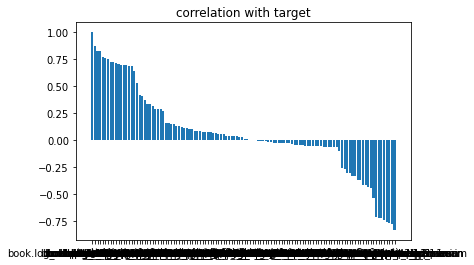

In [ ]:
# correlation table
columns = []
correlation_results = []

for col in tqdm(set(list(scaled_data.columns)) - set(['row_id'])):
    columns = columns + [col]
    cor_result = scaled_data['target'].corr(scaled_data[col])
    correlation_results = correlation_results + [cor_result]

target_correlation_df = pd.DataFrame({'features' : columns, 'correlation_results' : correlation_results}).sort_values(by = ['correlation_results'],\
                                                                                                                      ascending = [False])

print(target_correlation_df[(target_correlation_df.correlation_results > 0.7) | (target_correlation_df.correlation_results < -0.7)])

plt.bar(target_correlation_df['features'],target_correlation_df['correlation_results'])
plt.title('correlation with target')
plt.show()

128it [00:08, 14.51it/s]


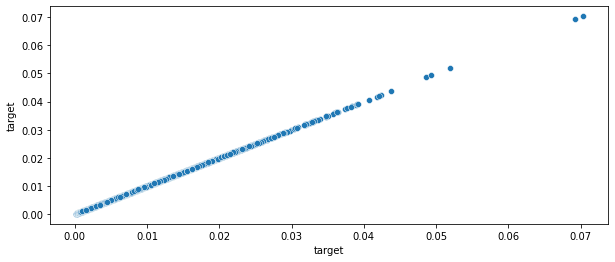

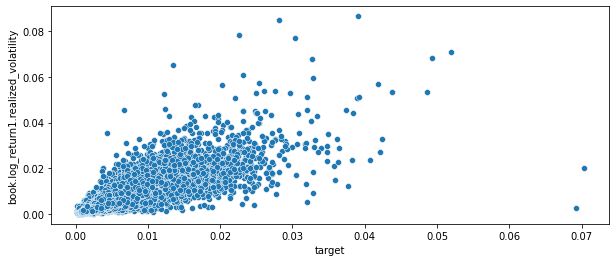

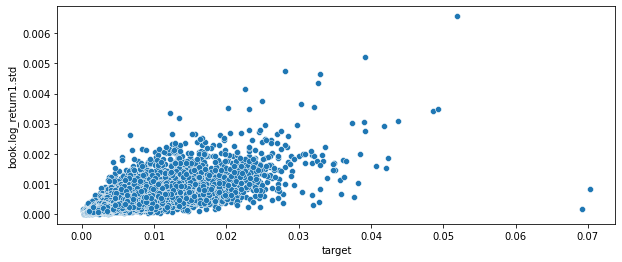

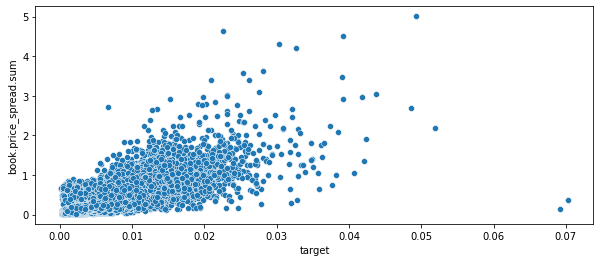

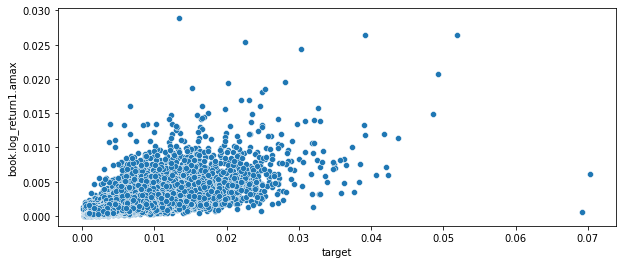

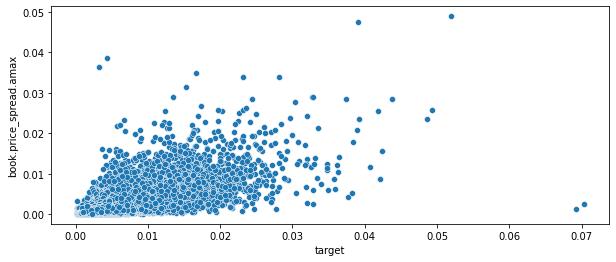

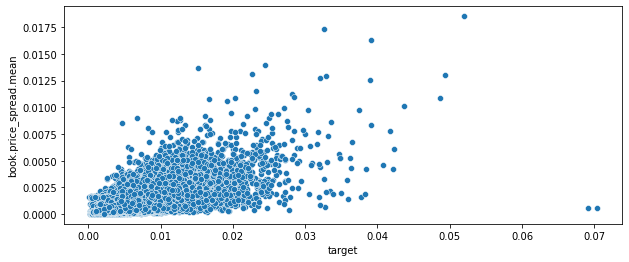

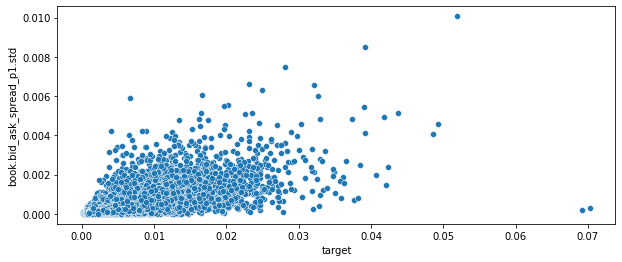

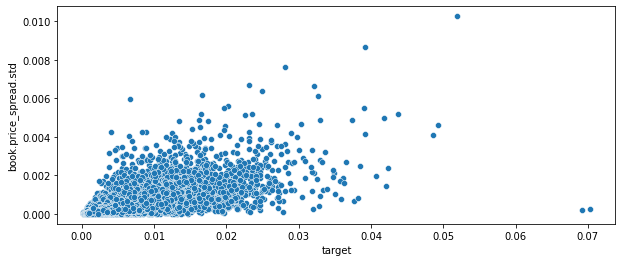

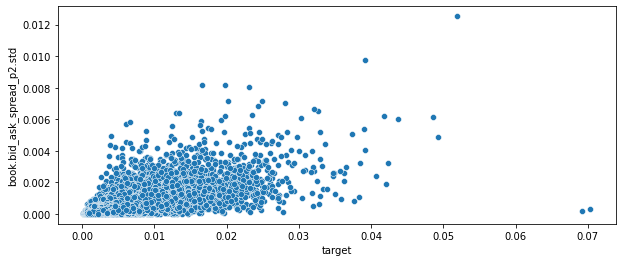

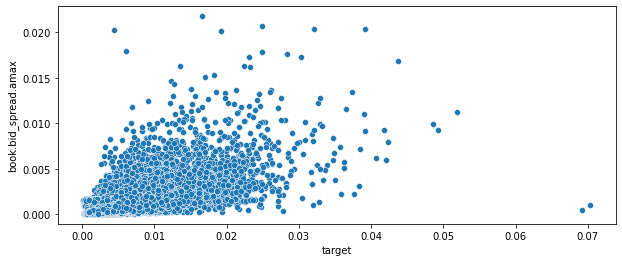

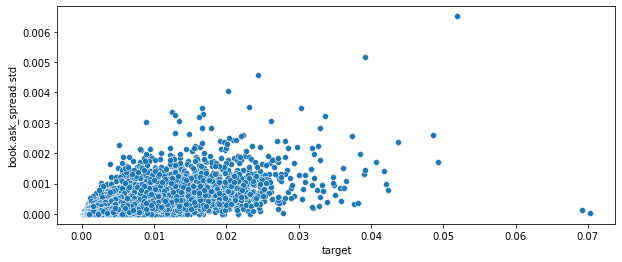

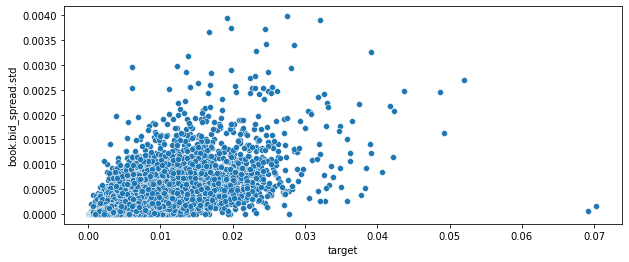

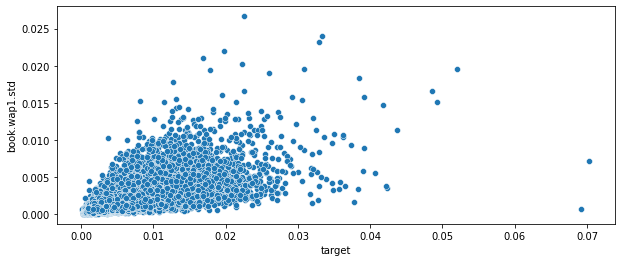

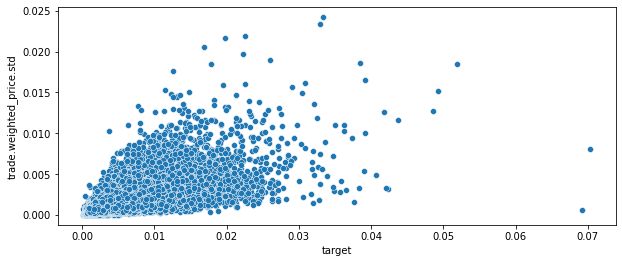

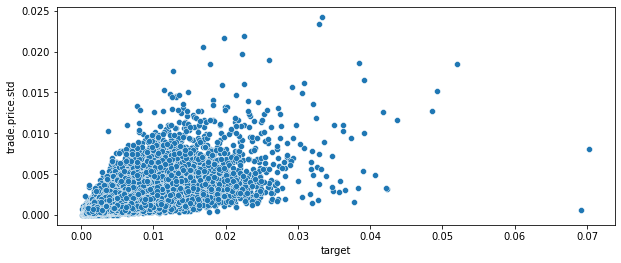

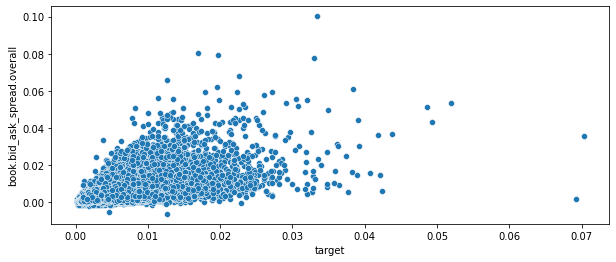

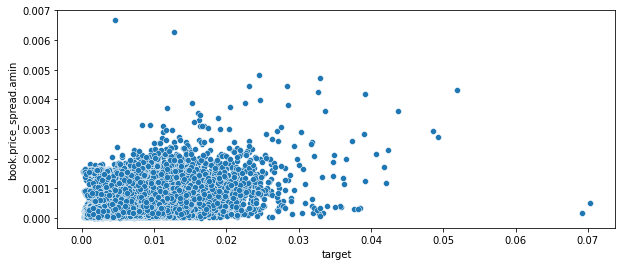

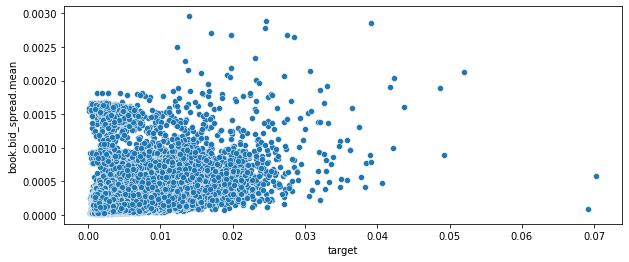

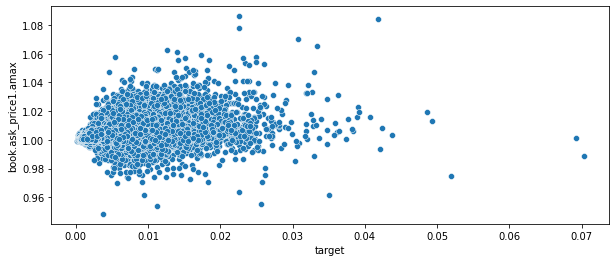

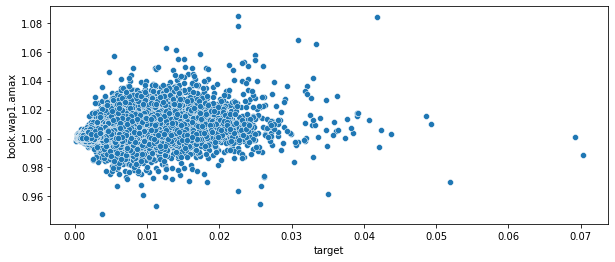

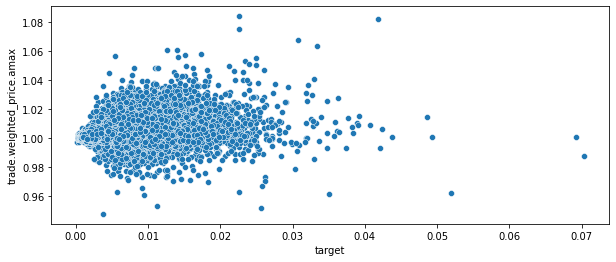

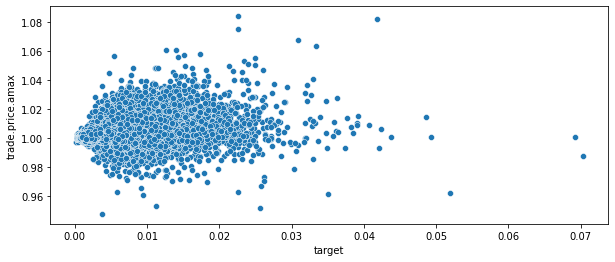

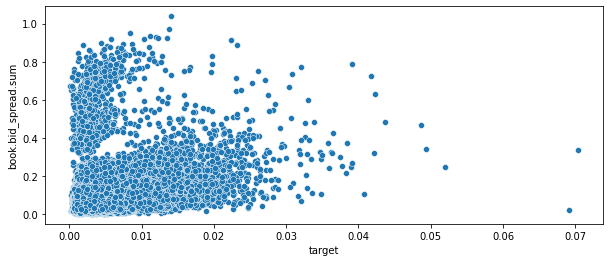

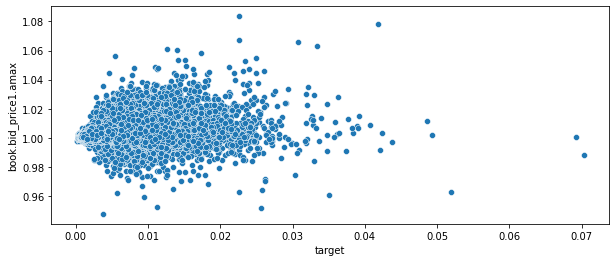

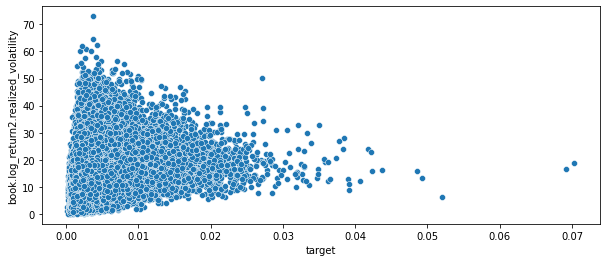

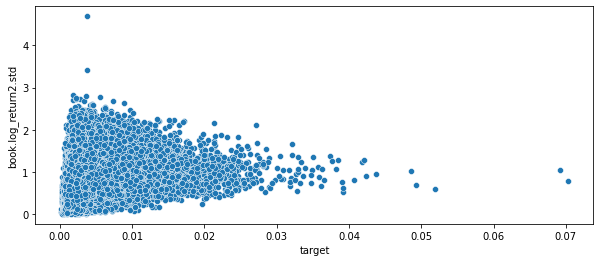

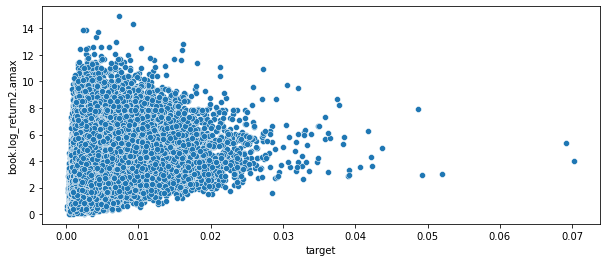

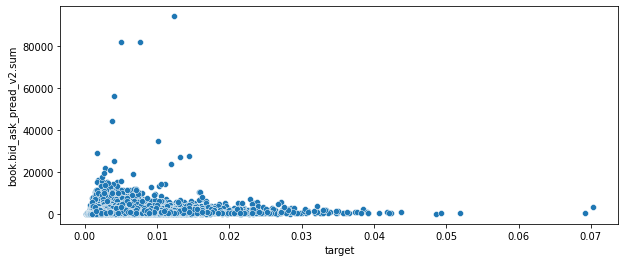

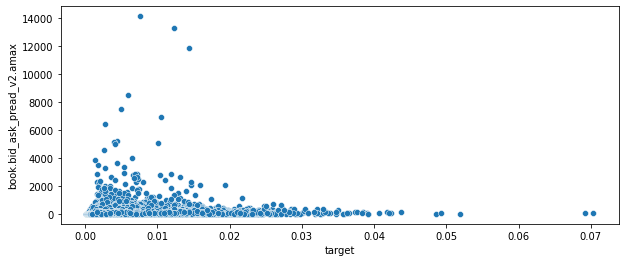

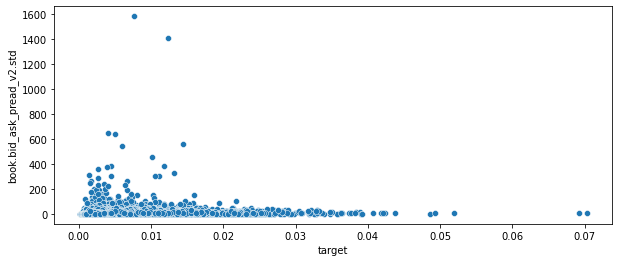

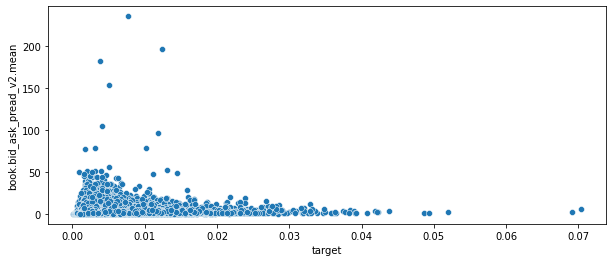

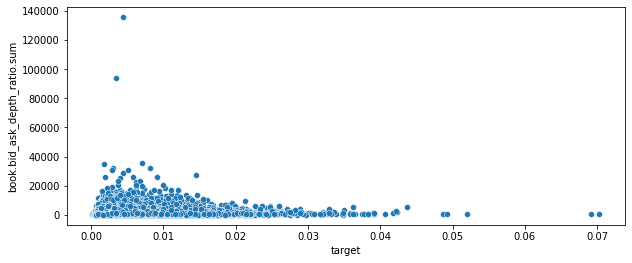

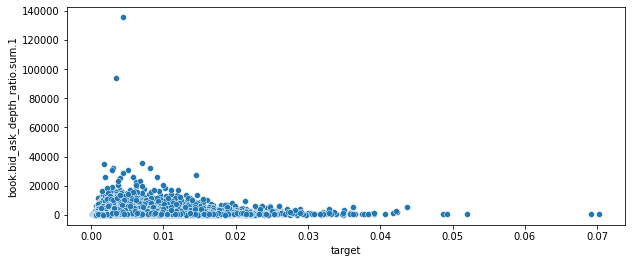

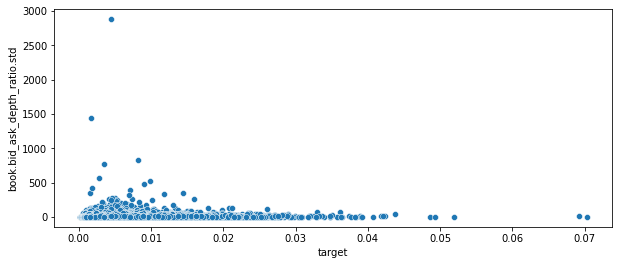

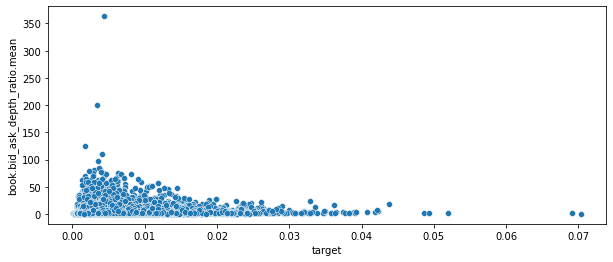

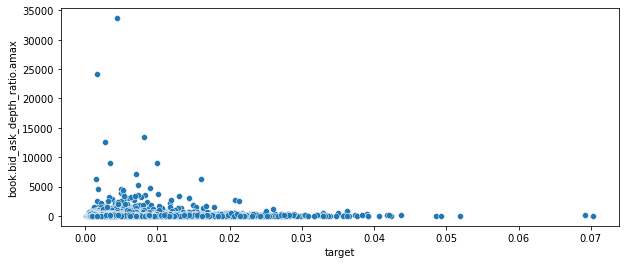

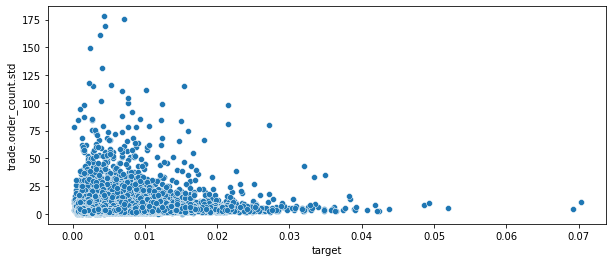

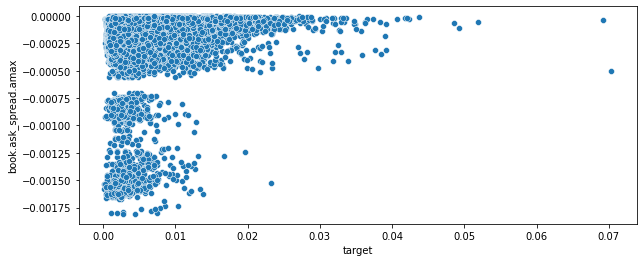

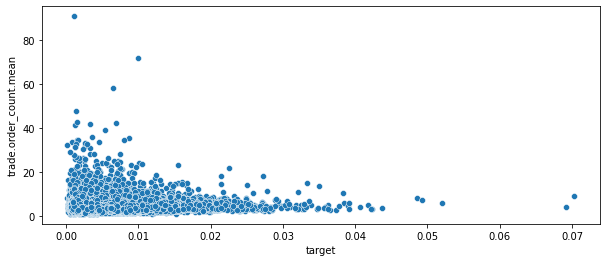

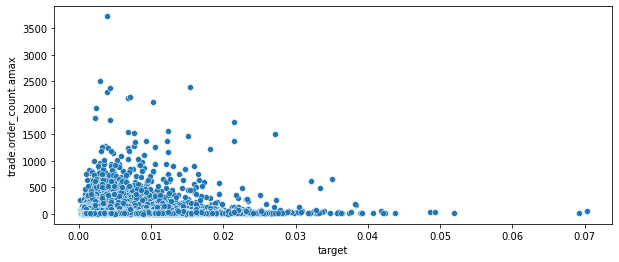

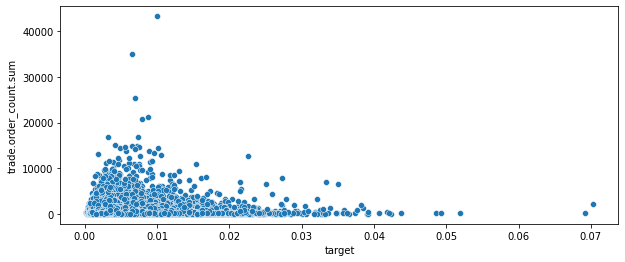

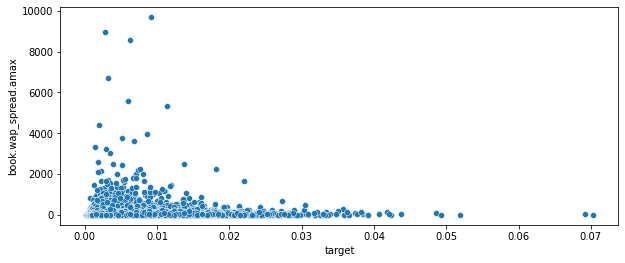

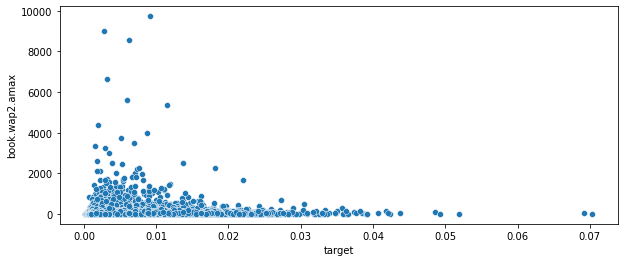

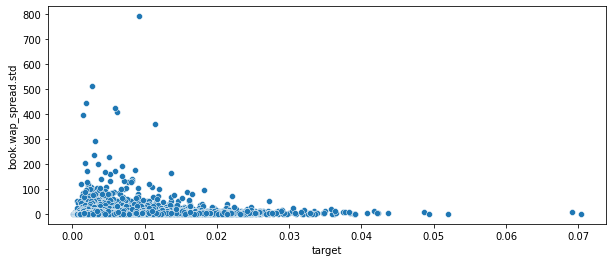

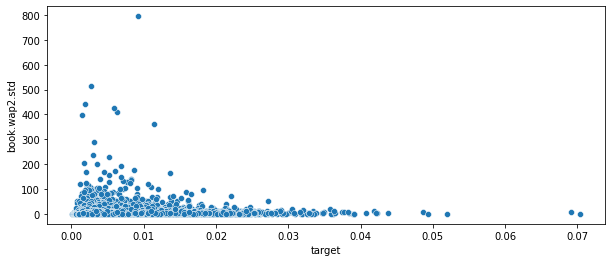

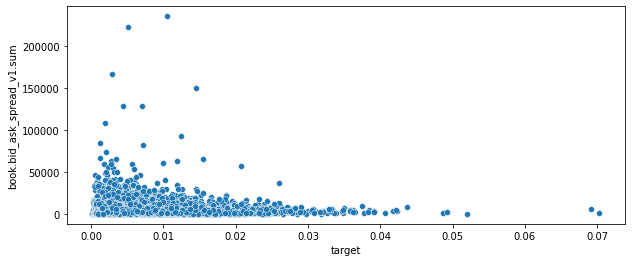

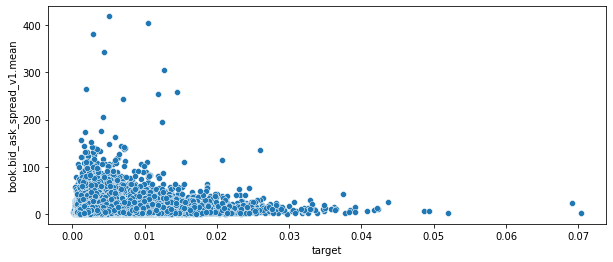

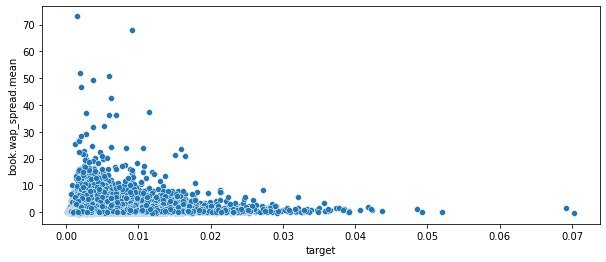

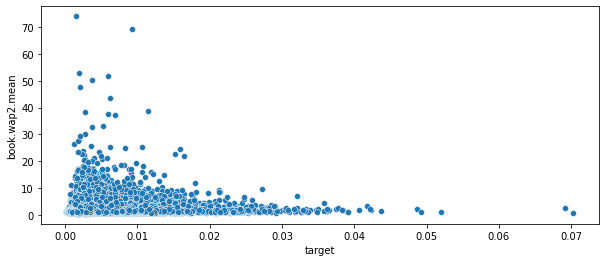

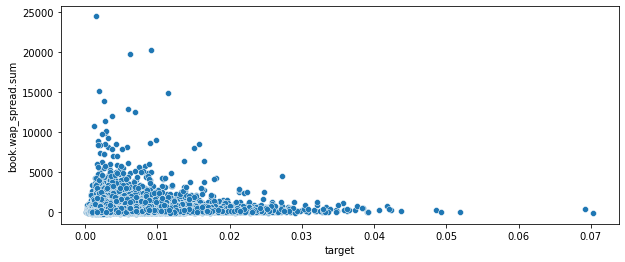

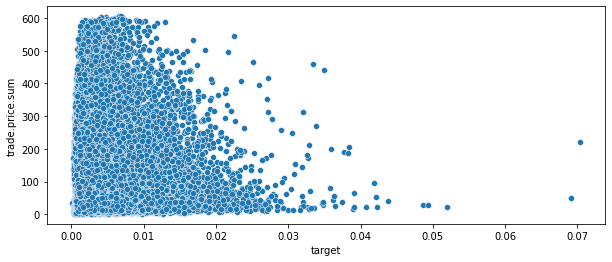

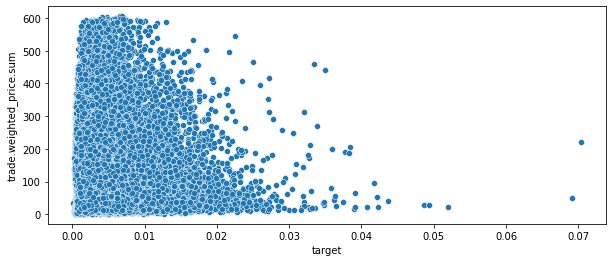

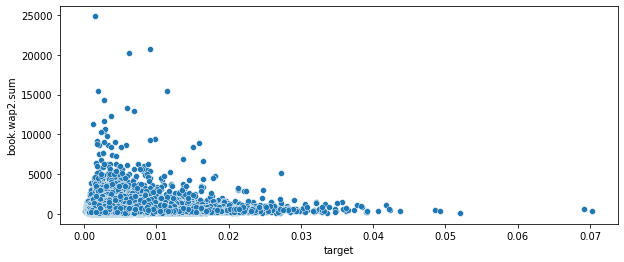

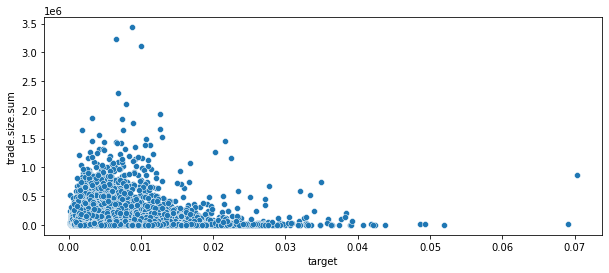

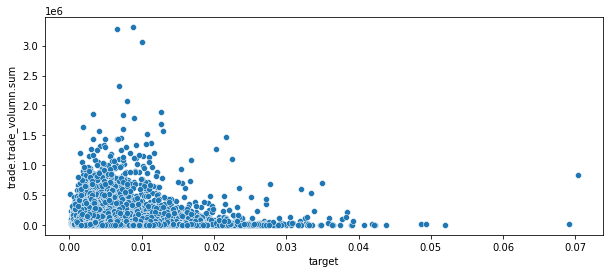

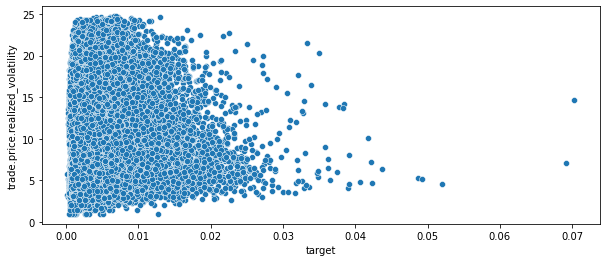

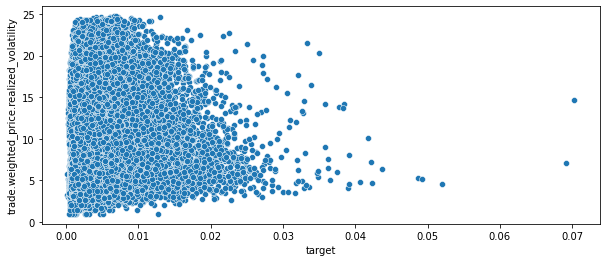

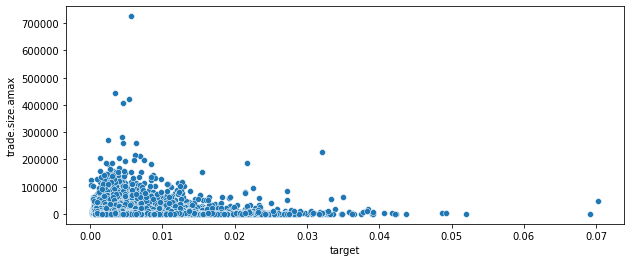

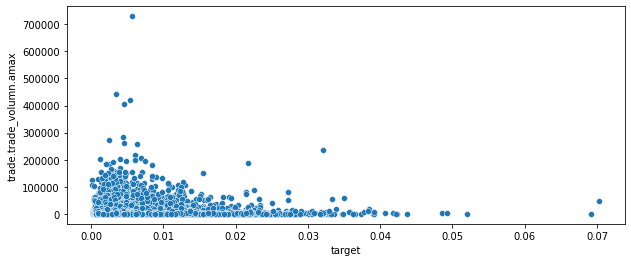

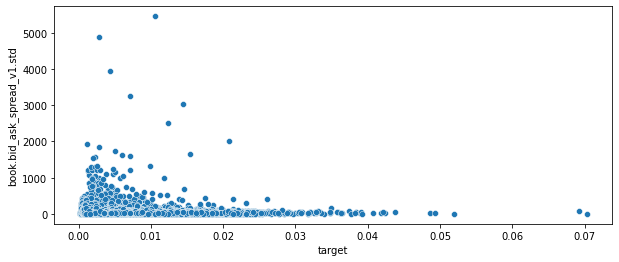

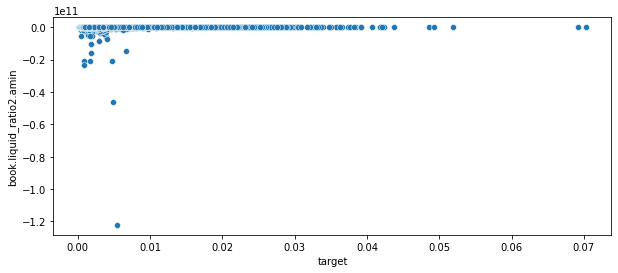

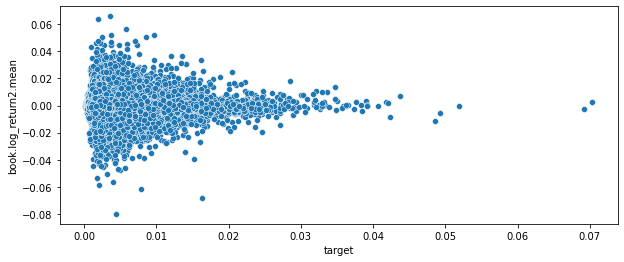

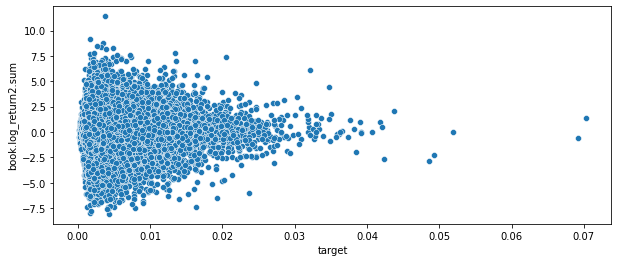

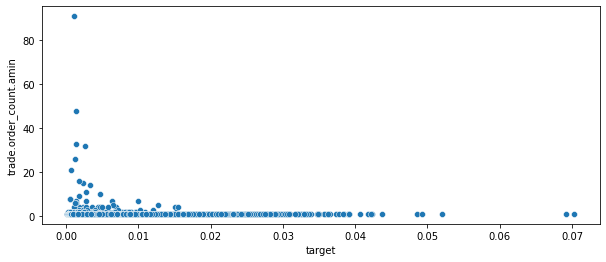

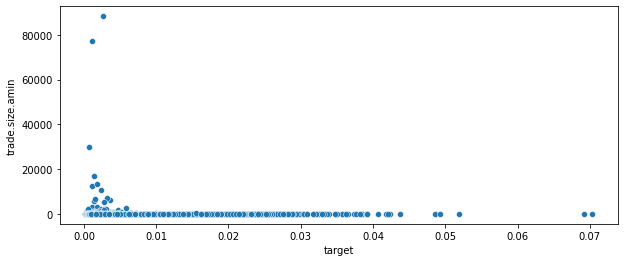

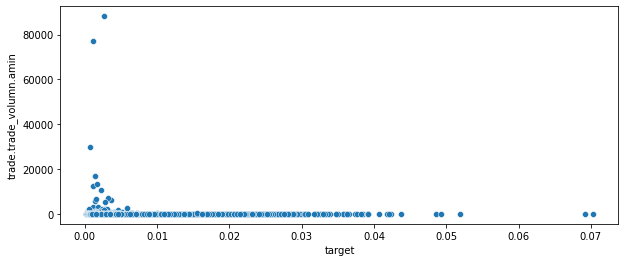

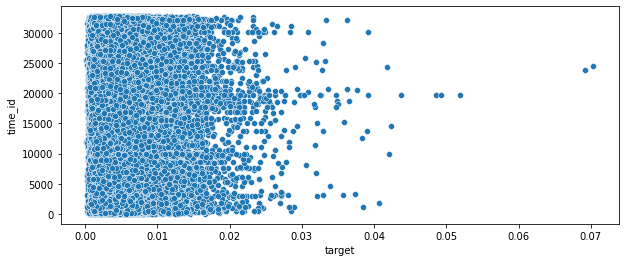

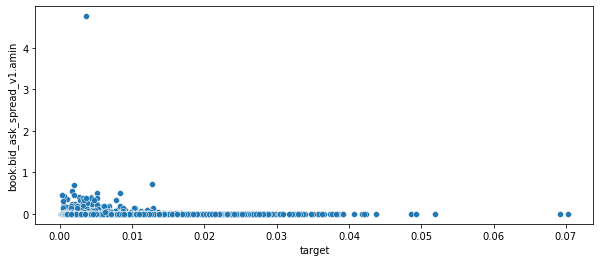

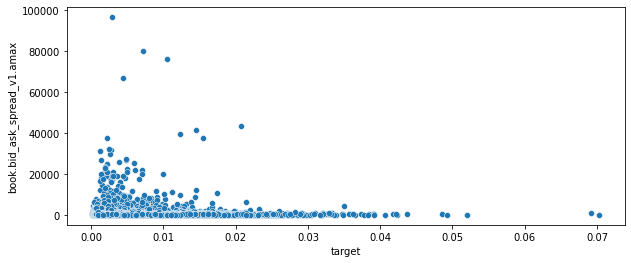

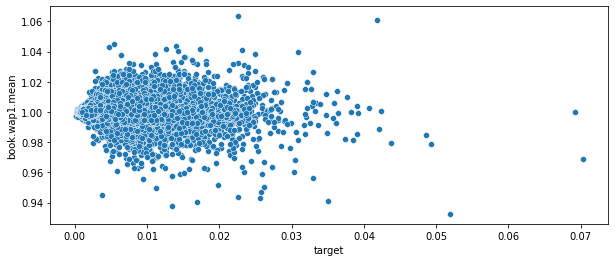

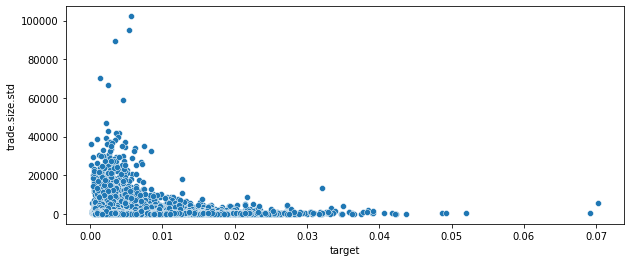

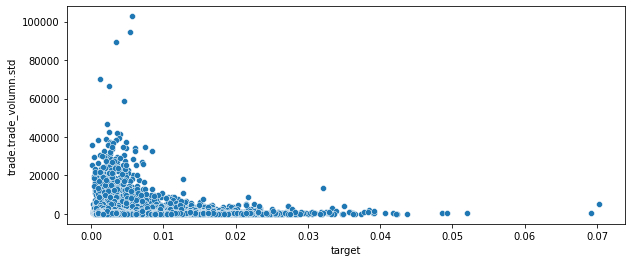

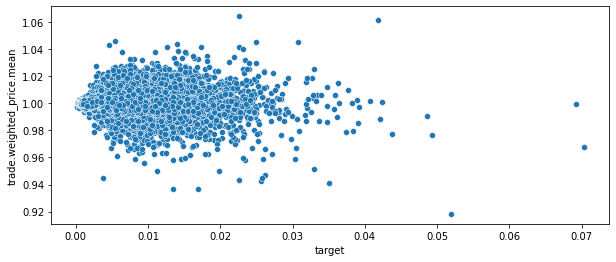

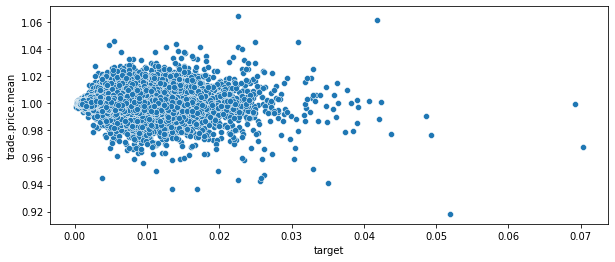

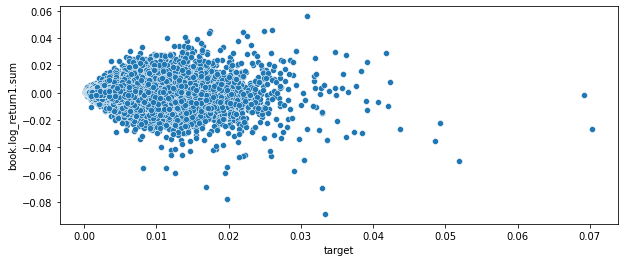

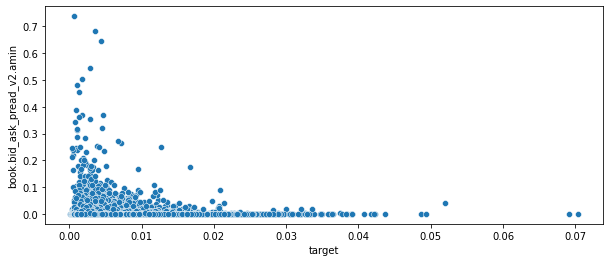

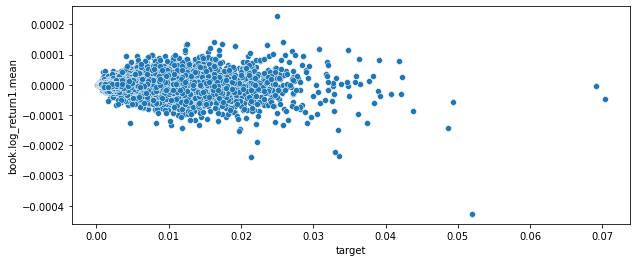

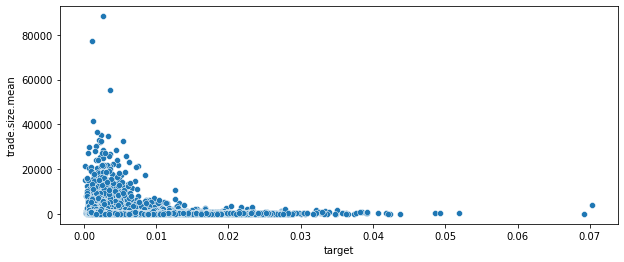

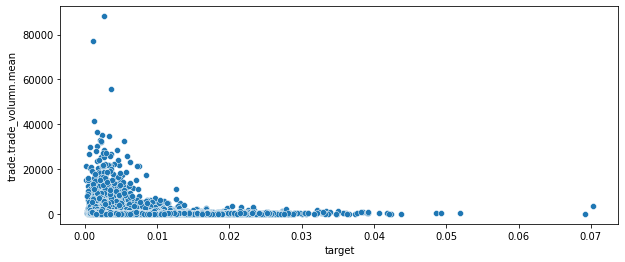

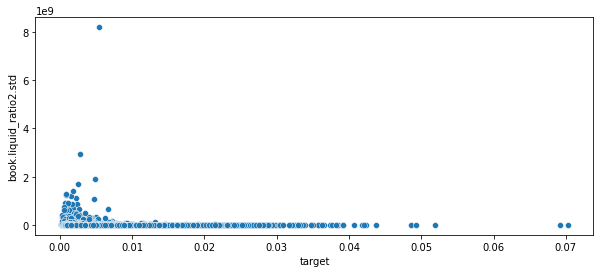

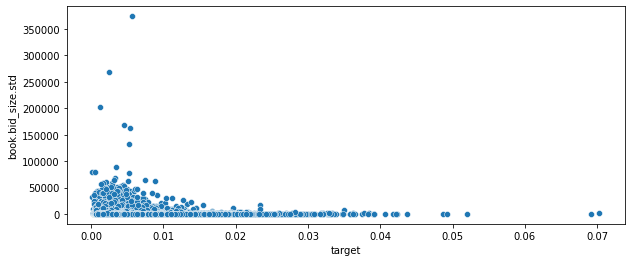

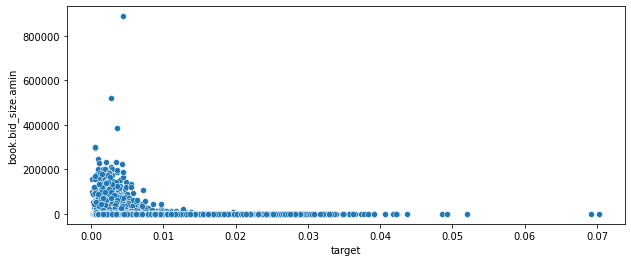

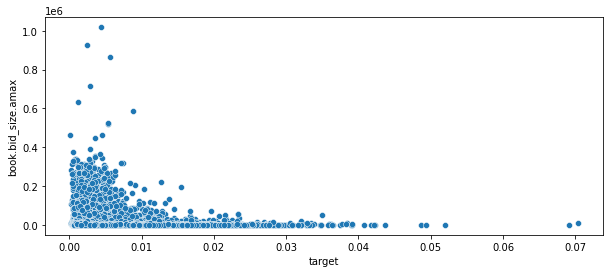

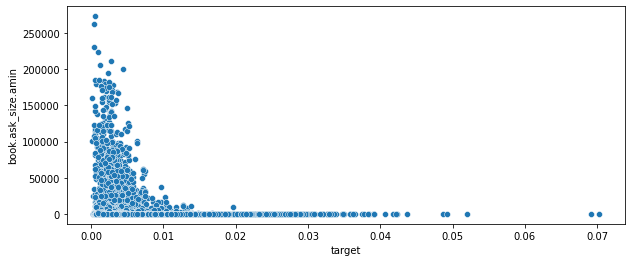

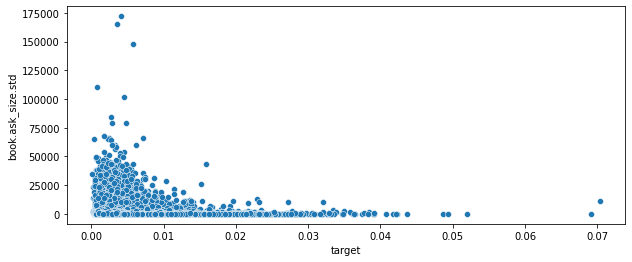

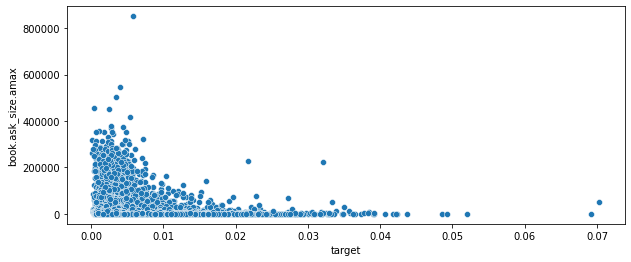

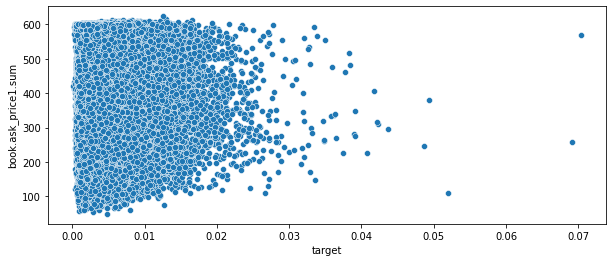

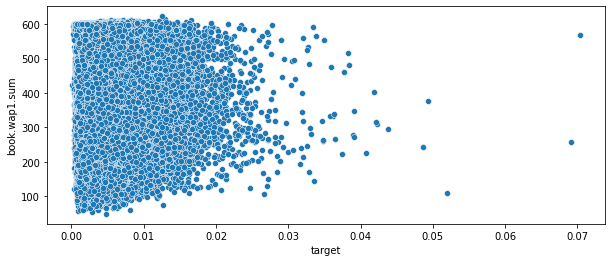

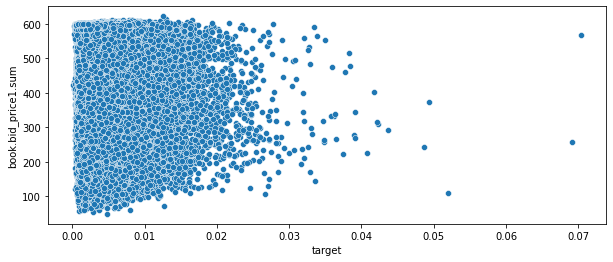

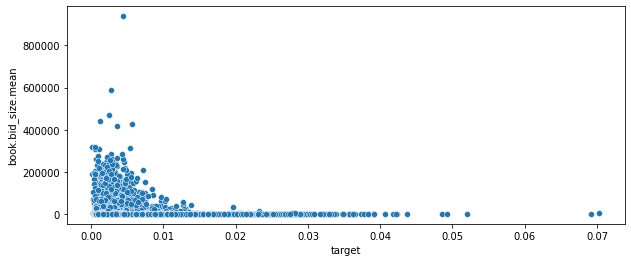

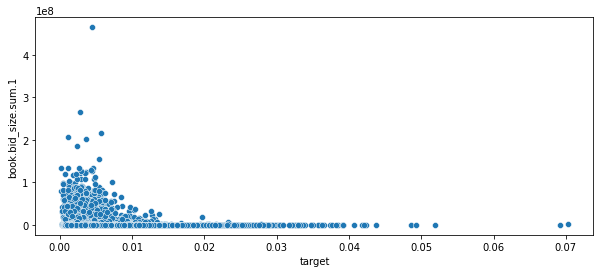

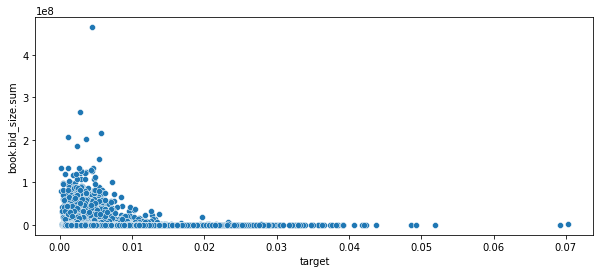

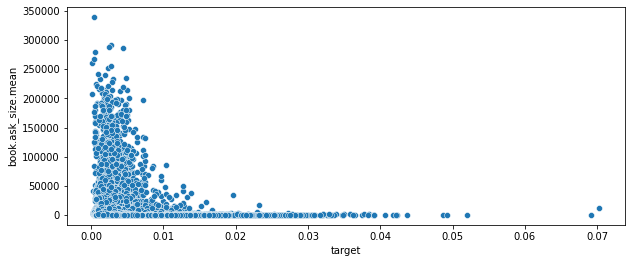

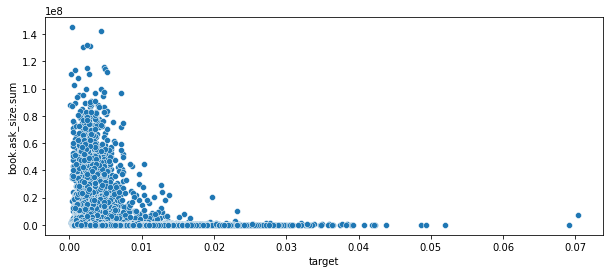

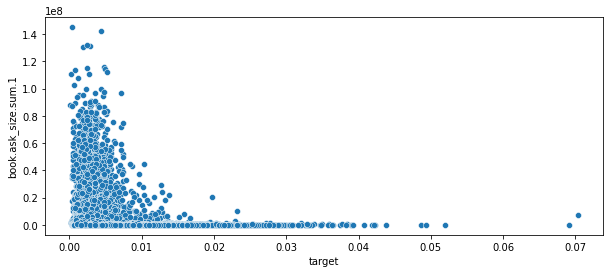

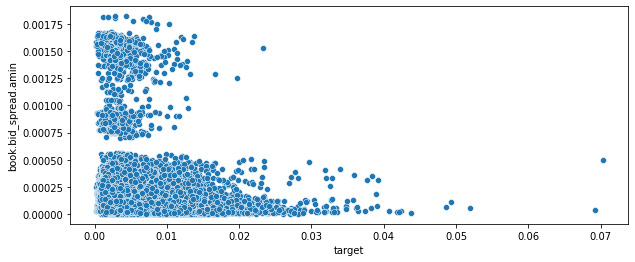

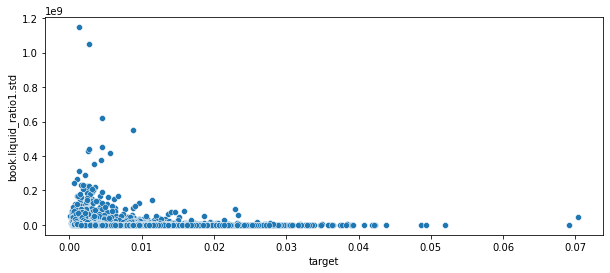

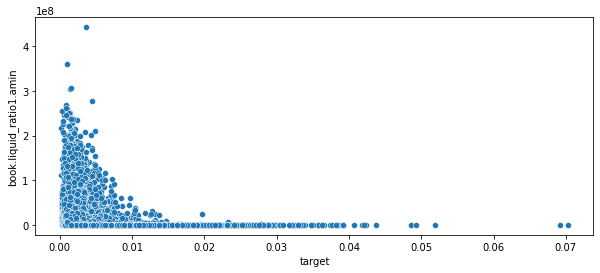

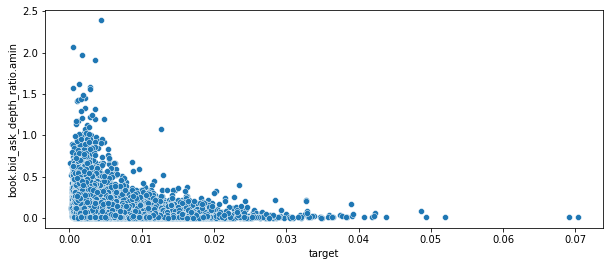

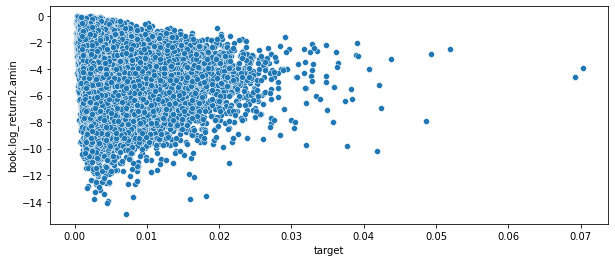

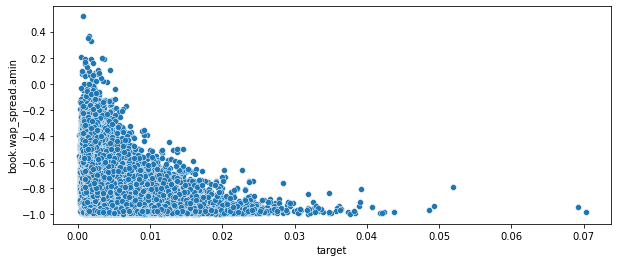

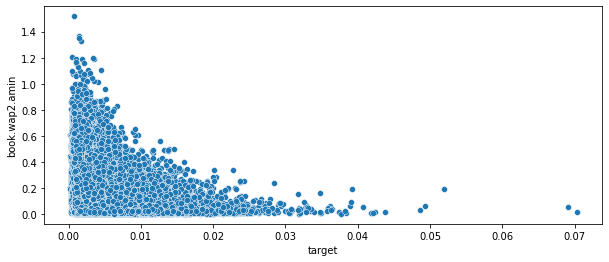

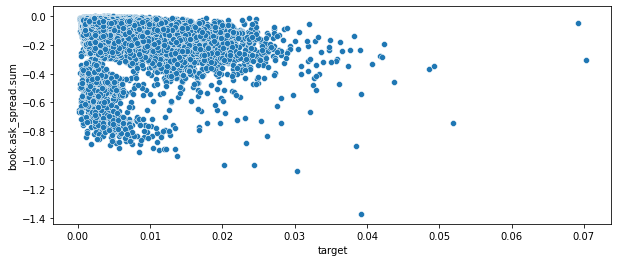

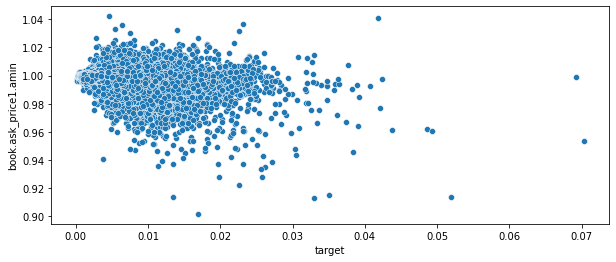

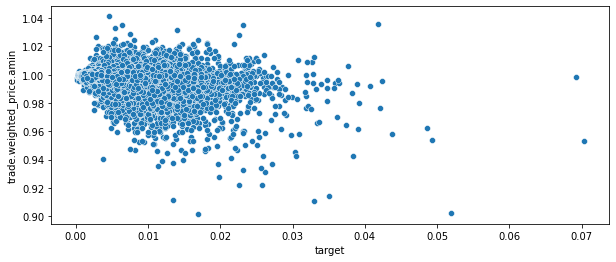

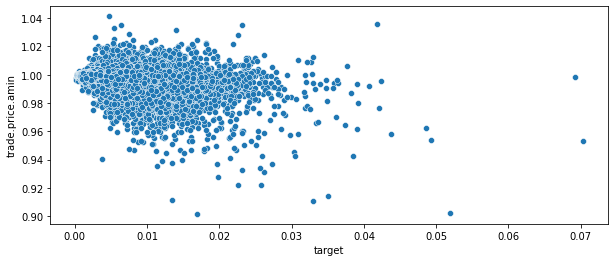

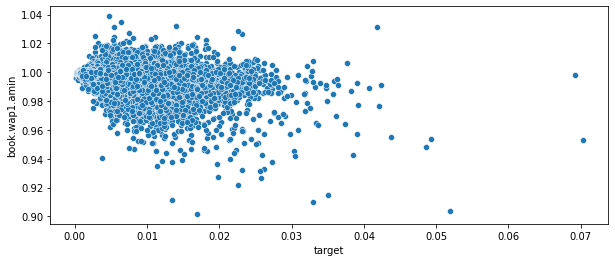

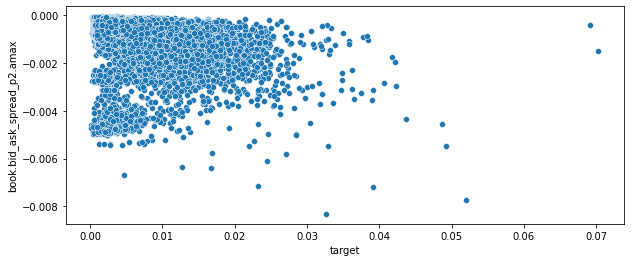

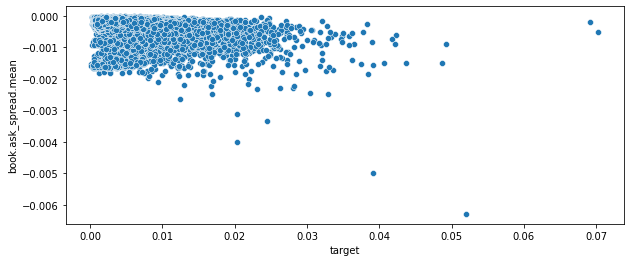

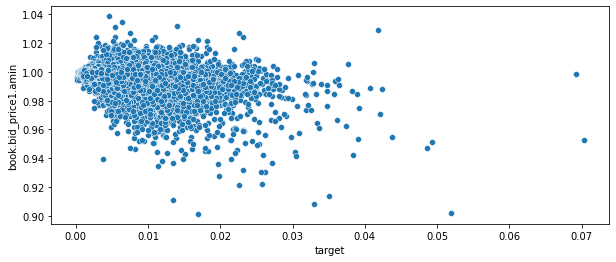

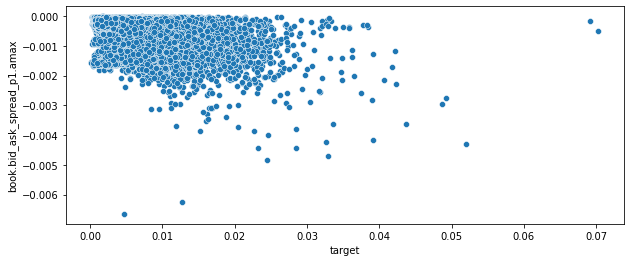

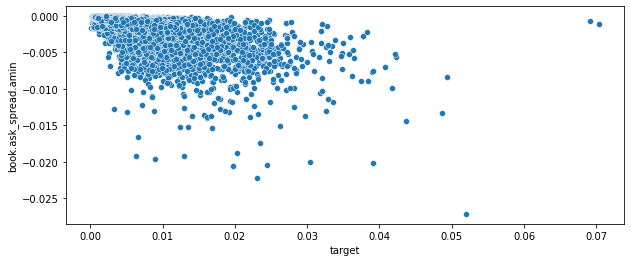

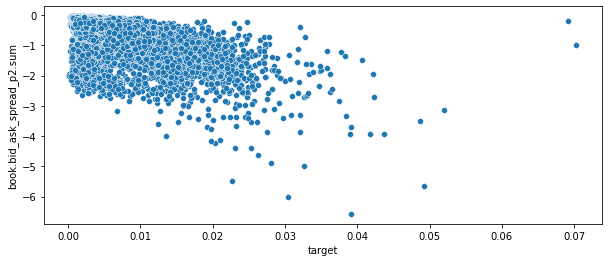

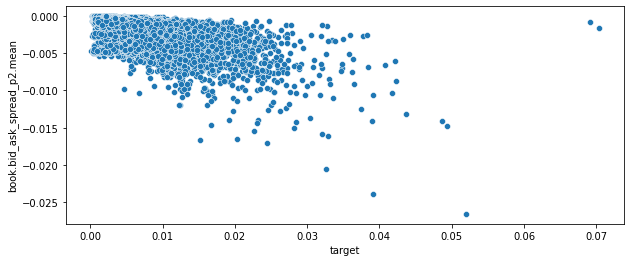

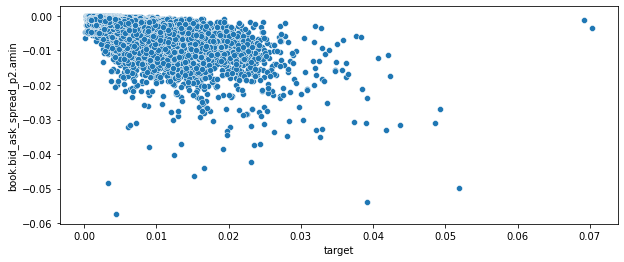

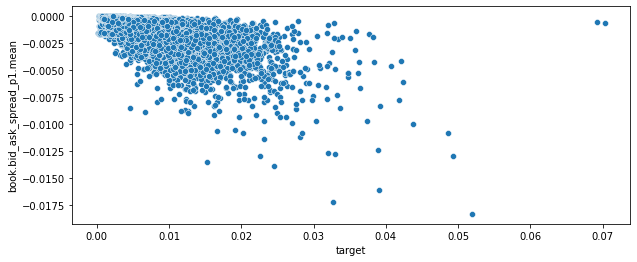

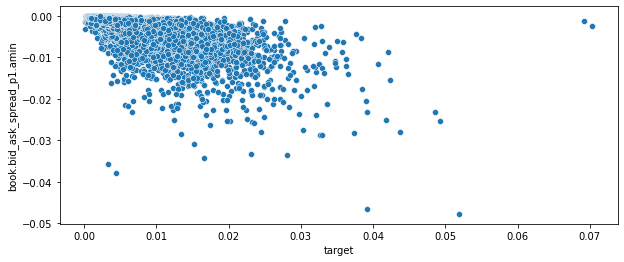

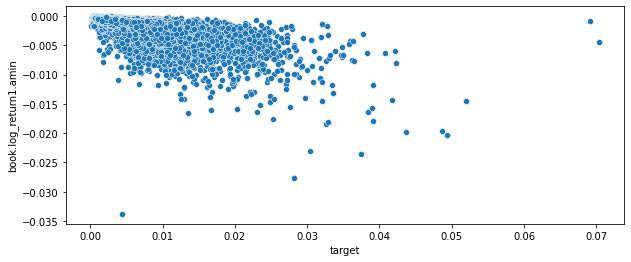

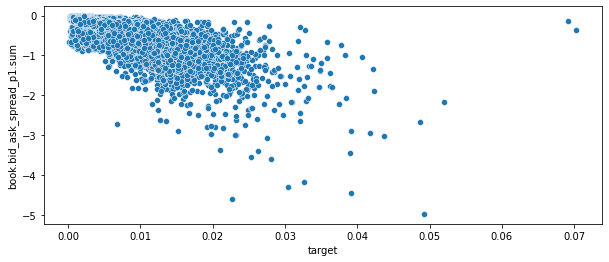

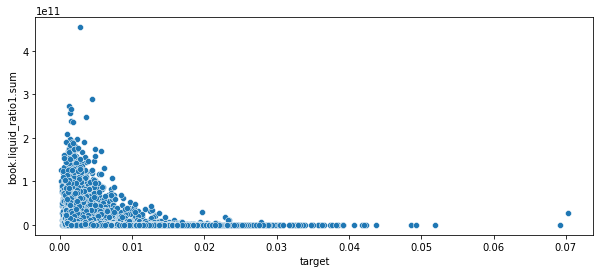

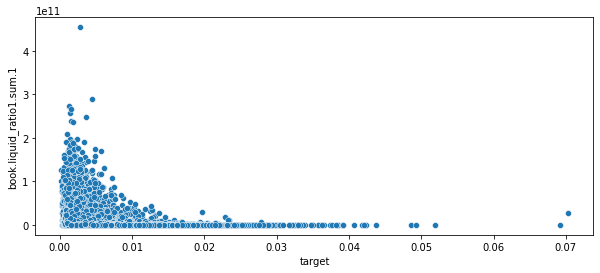

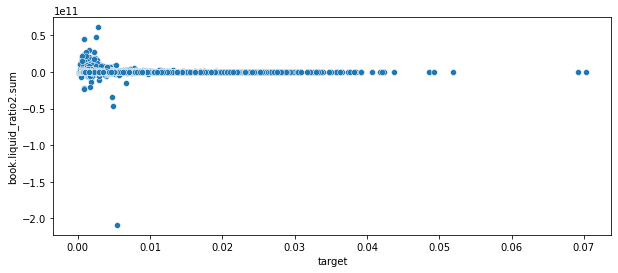

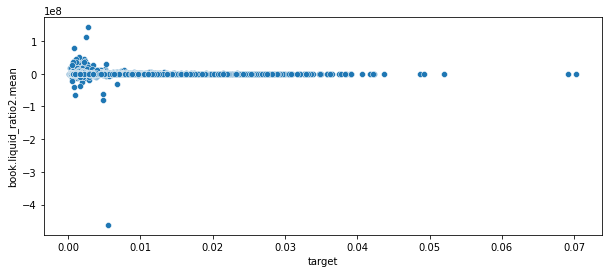

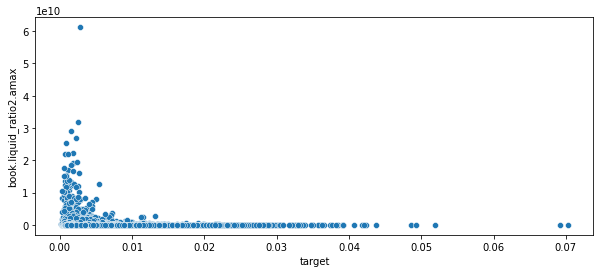

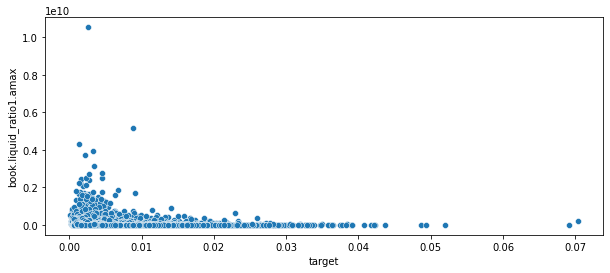

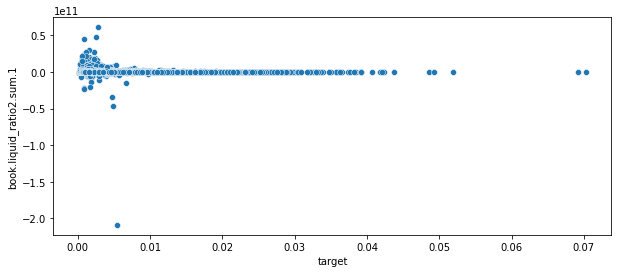

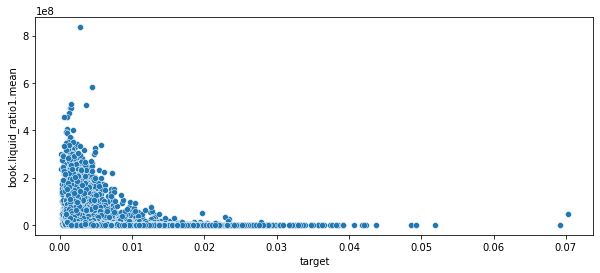

In [ ]:
# scatter plot
sample = scaled_data.sample(frac=0.25)
for i, col in tqdm(enumerate(target_correlation_df['features'])):
    plt.figure(i,figsize=(10, 4))
    sns.scatterplot(data = sample, y = col, x = "target")

## 3.7 Correlations

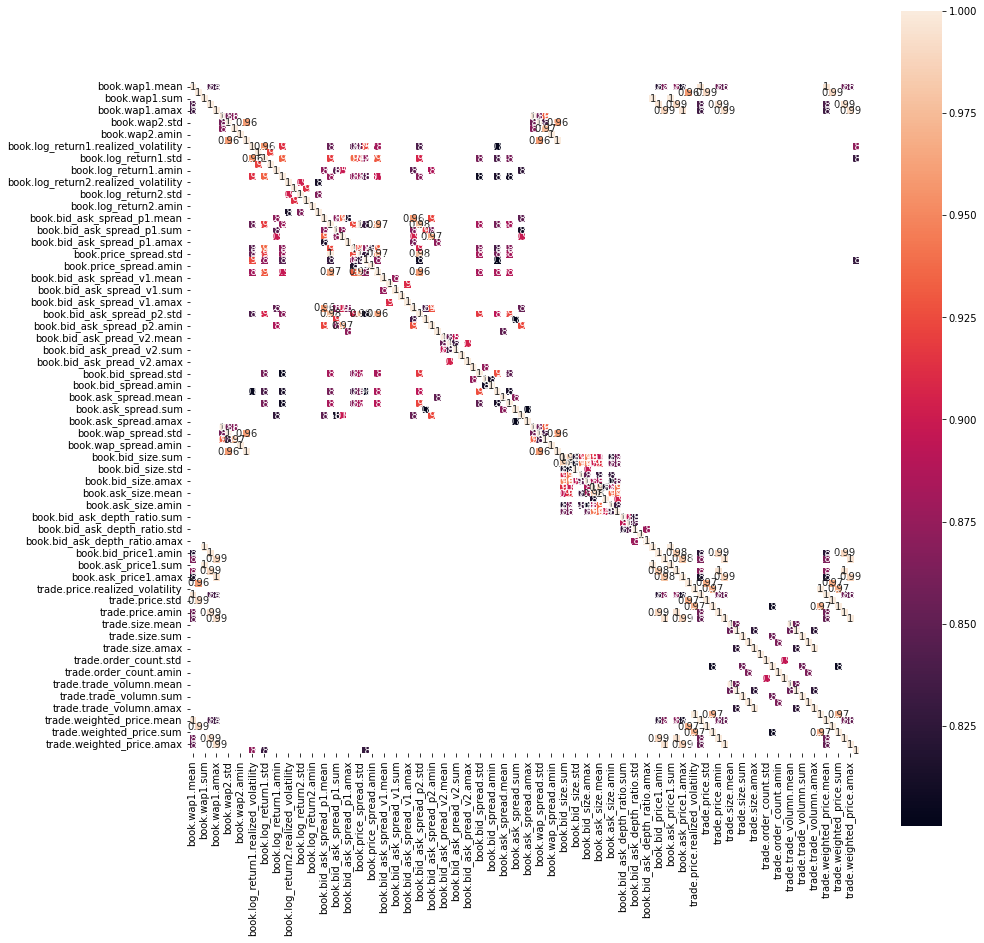

In [ ]:
# Calculate the Correlation matrix of data frame without the Dependent variable (Just on 25% of data)
corr_matrix = scaled_data[scaled_data.columns.drop(list(scaled_data.filter(regex='stock_id')))].sample(frac=0.25).corr()
kot = corr_matrix[corr_matrix>=.8]
# Plot the heatmap of Correlation
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(kot, vmax=1, annot=True, square=True);
plt.show()

In [ ]:
kot.head()

book.wap1.mean  book.wap1.std  book.wap1.sum  book.wap1.amin  \
book.wap1.mean        1.000000            NaN            NaN        0.841119   
book.wap1.std              NaN            1.0            NaN             NaN   
book.wap1.sum              NaN            NaN            1.0             NaN   
book.wap1.amin        0.841119            NaN            NaN        1.000000   
book.wap1.amax        0.834649            NaN            NaN             NaN   

                book.wap1.amax  book.wap2.mean  book.wap2.std  book.wap2.sum  \
book.wap1.mean        0.834649             NaN            NaN            NaN   
book.wap1.std              NaN             NaN            NaN            NaN   
book.wap1.sum              NaN             NaN            NaN            NaN   
book.wap1.amin             NaN             NaN            NaN            NaN   
book.wap1.amax        1.000000             NaN            NaN            NaN   

                book.wap2.amin  book.wap2.amax  ...  trade.trade_volumn.sum  \
book.wap1.mean             NaN             NaN  ...                     NaN   
book.wap1.std              NaN             NaN  ...                     NaN   
book.wap1.sum              NaN             NaN  ...                     NaN   
book.wap1.amin             NaN             NaN  ...                     NaN   
book.wap1.amax             NaN             NaN  ...                     NaN   

                trade.trade_volumn.amin  trade.trade_volumn.amax  \
book.wap1.mean                      NaN                      NaN   
book.wap1.std                       NaN                      NaN   
book.wap1.sum                       NaN                      NaN   
book.wap1.amin                      NaN                      NaN   
book.wap1.amax                      NaN                      NaN   

                trade.weighted_price.realized_volatility  \
book.wap1.mean                                       NaN   
book.wap1.std                                        NaN   
book.wap1.sum                                        NaN   
book.wap1.amin                                       NaN   
book.wap1.amax                                       NaN   

                trade.weighted_price.mean  trade.weighted_price.std  \
book.wap1.mean                   0.996685                       NaN   
book.wap1.std                         NaN                  0.990191   
book.wap1.sum                         NaN                       NaN   
book.wap1.amin                   0.840813                       NaN   
book.wap1.amax                   0.833809                       NaN   

                trade.weighted_price.sum  trade.weighted_price.amin  \
book.wap1.mean                       NaN                   0.856781   
book.wap1.std                        NaN                        NaN   
book.wap1.sum                        NaN                        NaN   
book.wap1.amin                       NaN                   0.993976   
book.wap1.amax                       NaN                        NaN   

                trade.weighted_price.amax  target  
book.wap1.mean                   0.850375     NaN  
book.wap1.std                         NaN     NaN  
book.wap1.sum                         NaN     NaN  
book.wap1.amin                        NaN     NaN  
book.wap1.amax                   0.993491     NaN  

[5 rows x 112 columns]

In [ ]:
def remove_high_correlation(df):
    corr_threshold = 0.8
    corr_matrix = df.sample(frac=0.25).corr()
    corr_matrix = corr_matrix.abs()

    # upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # columns with correlation > threshold
    to_drop_corr = [column for column in upper.columns if any(upper[column] >= corr_threshold)]
    new_df = df.drop(columns=to_drop_corr)

    return [new_df, len(to_drop_corr)]

In [ ]:
target_table = scaled_data[['row_id','target']]
features = scaled_data.drop(columns = ['target'])

In [ ]:
drophighcor_data = remove_high_correlation(features)[0]
print(len(features.columns))
print(remove_high_correlation(features)[1])

113
87


In [ ]:
data_drop = drophighcor_data.merge(target_table, on = 'row_id', how = 'left')
data_drop

row_id  book.wap1.mean  book.wap1.std  book.wap1.sum  book.wap2.mean  \
0          99-5        0.531519       0.000886       0.826994        0.003835   
1         99-11        0.512842       0.000480       0.596574        0.002566   
2         99-16        0.502149       0.000250       0.559479        0.002705   
3         99-31        0.510354       0.000669       0.668401        0.003091   
4         99-62        0.503038       0.000522       0.543203        0.002456   
...         ...             ...            ...            ...             ...   
428927  0-32751        0.497632       0.000747       0.446235        0.007431   
428928  0-32753        0.512279       0.000551       0.298262        0.002001   
428929  0-32758        0.507596       0.000743       0.268531        0.005636   
428930  0-32763        0.524917       0.000356       0.464806        0.005362   
428931  0-32767        0.504949       0.000765       0.333871        0.001682   

        book.wap2.amin  book.log_return1.realized_volatility  \
0             0.182474                              0.002085   
1             0.128292                              0.001024   
2             0.106748                              0.001888   
3             0.069313                              0.001481   
4             0.226220                              0.000995   
...                ...                                   ...   
428927        0.002568                              0.002579   
428928        0.001449                              0.002206   
428929        0.034633                              0.002913   
428930        0.004219                              0.003046   
428931        0.117429                              0.001901   

        book.log_return1.mean  book.log_return2.realized_volatility  \
0                3.736569e-06                              0.127897   
1                1.283303e-06                              0.068850   
2                1.058346e-07                              0.127765   
3                4.810219e-06                              0.108463   
4               -3.263362e-06                              0.062701   
...                       ...                                   ...   
428927          -7.215157e-06                              0.284841   
428928           1.966770e-06                              0.235759   
428929           8.895445e-06                              0.188724   
428930           1.698933e-06                              0.289130   
428931          -6.696126e-06                              0.105533   

        book.log_return2.mean  ...  book.bid_ask_depth_ratio.sum  \
0                    0.001452  ...                      0.004598   
1                   -0.000015  ...                      0.002677   
2                   -0.001663  ...                      0.002906   
3                   -0.000908  ...                      0.003546   
4                    0.000801  ...                      0.003362   
...                       ...  ...                           ...   
428927              -0.003361  ...                      0.013603   
428928              -0.010881  ...                      0.002379   
428929              -0.000946  ...                      0.001287   
428930              -0.001008  ...                      0.007283   
428931              -0.001442  ...                      0.006770   

        book.bid_ask_depth_ratio.amin  trade.price.realized_volatility  \
0                            0.028799                         0.424306   
1                            0.042528                         0.268560   
2                            0.025802                         0.304383   
3                            0.033580                         0.304847   
4                            0.037578                         0.239143   
...                               ...                              ...   
428927                       0.001044                         0.256456   
42892

In [ ]:
#data_drop.to_csv(f'{root_path}/data_drop.csv', index = False)
#data_drop = pd.read_csv(f'{root_path}/data_drop.csv')

## 3.8 Training - validation - testing split

In [ ]:
scaled_data = pd.read_csv(f'{root_path}/scaled_data.csv')
data_drop = pd.read_csv(f'{root_path}/data_drop.csv')

scaled_data = pd.get_dummies(scaled_data, prefix=['stock_id'], columns=['stock_id'])
data_drop = pd.get_dummies(data_drop, prefix=['stock_id'], columns=['stock_id'])

# define metric
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

#define our own metric and set greater_is_better=False
rmspe_fit = make_scorer(rmspe,greater_is_better=False)

def get_X_y(data):
  Xfeature = data.drop(columns = ["row_id","target"])
  y = data["target"]
  return Xfeature,y

Xfull, yfull = get_X_y(scaled_data)
Xdrop, ydrop = get_X_y(data_drop)

Xfull_train, Xfull_test, yfull_train, yfull_test = train_test_split(Xfull, yfull, test_size = 0.2, random_state = 42)
Xdrop_train, Xdrop_test, ydrop_train, ydrop_test = train_test_split(Xdrop, ydrop, test_size = 0.2, random_state = 42)

print('full dataset')
print(f'X_train: {Xfull_train.shape}')
print(f'y_train: {yfull_train.shape}')
print(f'X_test: {Xfull_test.shape}')
print(f'y_test: {yfull_test.shape}')
print('')

print('drop dataset')
print(f'X_train: {Xdrop_train.shape}')
print(f'y_train: {ydrop_train.shape}')
print(f'X_test: {Xdrop_test.shape}')
print(f'y_test: {ydrop_test.shape}')
print('')


full dataset
X_train: (343145, 223)
y_train: (343145,)
X_test: (85787, 223)
y_test: (85787,)

drop dataset
X_train: (343145, 135)
y_train: (343145,)
X_test: (85787, 135)
y_test: (85787,)



# 4. Modelling

Some basic models are tried to have insights

#### 4.1 Elasticnet Regression

Tunning models

In [ ]:
param_grid_ElasticNet = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1.0],
    'fit_intercept': [True,False],
    'l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'normalize': [True,False],
    'positive': [True,False],
    'precompute': [True,False],
    'random_state': [42],
    'tol': [0.0001,0.001], 
    'warm_start': [True,False]
}

In [ ]:
def elasticnet_model(X,y):
  global param_grid_ElasticNet
  elasticnet = linear_model.ElasticNet()
  randomsearch = RandomizedSearchCV(elasticnet, param_distributions = param_grid_ElasticNet, cv=3, scoring=rmspe_fit, verbose=True, n_jobs=-1, return_train_score = True)
  
  best_clf = randomsearch.fit(X, y)
  return best_clf

In [ ]:
%%time
# full data 
elasticnet_model_cv_result = elasticnet_model(Xfull_train, yfull_train)

In [ ]:
scoring_val = -elasticnet_model_cv_result.best_score_
best_param = elasticnet_model_cv_result.best_params_
best_index = elasticnet_model_cv_result.best_index_
mean_test_score = elasticnet_model_cv_result.cv_results_["mean_test_score"][best_index]
mean_train_score = elasticnet_model_cv_result.cv_results_["mean_train_score"][best_index]

In [ ]:
print(f'scoring_val: {scoring_val}')
print(f'best_param: {best_param}')
print(f'best_index: {best_index}')
print(f'scoring_train: {mean_train_score}')
print(f'scoring_val: {mean_test_score}')

In [ ]:
# drop data
elasticnet_model_cv_result_drop = elasticnet_model(Xdrop_train, ydrop_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:

scoring_val_drop = -elasticnet_model_cv_result_drop.best_score_
best_param_drop = elasticnet_model_cv_result_drop.best_params_
best_index_drop = elasticnet_model_cv_result_drop.best_index_
mean_test_score_drop = elasticnet_model_cv_result_drop.cv_results_["mean_test_score"][best_index_drop]
mean_train_score_drop = elasticnet_model_cv_result_drop.cv_results_["mean_train_score"][best_index_drop]

In [ ]:
print(f'scoring_val_drop: {scoring_val_drop}')
print(f'best_param_drop: {best_param_drop}')
print(f'best_index_drop: {best_index_drop}')
print(f'scoring_val_drop:{mean_test_score_drop}')
print(f'scoring_train_drop: {mean_train_score_drop}')

#### 4.2 Decision Tree

Baseline models

In [ ]:
def get_scores(a,c):
  decisiontree =  DecisionTreeRegressor()
  scores = cross_validate(decisiontree, a,c, scoring=rmspe_fit)
  return statistics.mean(scores['test_score'])

for a,b,c,d in tqdm (zip (Xfull_train_list,Xfull_test_list,yfull_train_list,yfull_test_list)) :
    print(len(a.columns))
    print(len(b.columns))
    rs = get_scores(a = a, c = c)
    print(rs)
    decision_scoring_val = decision_scoring_val + [rs]
    print('')

feature_threshold_list = [30,35,40,45,50,55,60,65,70,75,80,85,90,95,105]
decision_pfm = pd.DataFrame(
    {'feature_threshold': feature_threshold_list,
     'validation_score': decision_scoring_val
    })
# plot
plt.plot(decision_pfm.feature_threshold, -decision_pfm.validation_score)
# display
plt.show()

### Optimize Model

In [ ]:
%%time
#full data
decisiontree_hyperparameter = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

def decisiontree_model(X,y,cv):
  global decisiontree_hyperparameter  
  decisiontree =  DecisionTreeRegressor()
  randomsearch = RandomizedSearchCV(decisiontree, param_distributions = decisiontree_hyperparameter, cv=cv, scoring=rmspe_fit, verbose=True, n_jobs=-1, return_train_score = True)
  
  best_clf = randomsearch.fit(X, y)
  return best_clf

decisiontree_optimize_result = decisiontree_model(Xfull_train,yfull_train,cv = 3)

print(f'scoring_val_optimize_tree: {-decisiontree_optimize_result.best_score_}')
print(f'best_param_optimze_tree: {decisiontree_optimize_result.best_params_}')
print(f'best_index_optimize_tree: {decisiontree_optimize_result.best_index_}')
print(f'scoring_train_optimize_tree: {-decisiontree_optimize_result.cv_results_["mean_train_score"][decisiontree_optimize_result.best_index_]}')

In [ ]:
decisiontree_hyperparameter = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

def decisiontree_model(X,y,cv):
  global decisiontree_hyperparameter  
  decisiontree =  DecisionTreeRegressor()
  randomsearch = RandomizedSearchCV(decisiontree, param_distributions = decisiontree_hyperparameter, cv=cv, scoring=rmspe_fit, verbose=True, n_jobs=-1, return_train_score = True)
  
  best_clf = randomsearch.fit(X, y)
  return best_clf

decisiontree_optimize_result = decisiontree_model(Xfull_train_list[10],yfull_train_list[10],cv = 3)

print(f'scoring_val_optimize_tree: {-decisiontree_optimize_result.best_score_}')
print(f'best_param_optimze_tree: {decisiontree_optimize_result.best_params_}')
print(f'best_index_optimize_tree: {decisiontree_optimize_result.best_index_}')
print(f'scoring_train_optimize_tree: {-decisiontree_optimize_result.cv_results_["mean_train_score"][decisiontree_optimize_result.best_index_]}')